In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import probplot
import glob
import time
from joblib import Parallel, delayed
import os

In [2]:
train = pd.read_csv('../input/beyond-analysis/train.csv')

In [3]:
train.head()

,UNIQUE_IDENTIFIER,SEQUENCE_NO,STATUS_CHECK,CATEGORY_1,CATEGORY_2,ACTIVE_YN,ENTRY,REVENUE,WINNINGS_1,WINNINGS_2,...,WITHDRAW_NUMBER,DEPOSIT_TRAILS,ENTRY_NUMBER,WINNINGS_NUMBER,PRACTICE_ENTRY,PRACTICE_WINNINGS,PRACTICE_ENTRY_NUMBER,PRACTICE_WINNINGS_NUMBER,Y1,Y2
0,98481267304,1,0,M,B,1,0.00000,0.000000,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.449287,101.369863
1,98481267304,2,0,M,B,1,0.13735,0.011550,0.0999,0.0,...,0.0,0.0,1.8,1.0,0.0,0.0,0.0,0.0,4.449287,101.369863
2,98481267304,3,0,M,B,1,0.15835,0.010425,0.0242,0.0,...,0.0,0.0,0.7,0.3,0.0,0.0,0.0,0.0,4.449287,101.369863
3,98481267304,4,0,M,B,1,0.44490,0.035850,0.2398,0.0,...,0.0,0.0,2.8,1.5,0.0,0.0,0.0,0.0,4.449287,101.369863
4,98481267304,5,0,M,B,1,0.00000,0.000000,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.449287,101.369863


In [4]:
a = {}
for i in train.columns:
    if(i=='UNIQUE_IDENTIFIER'):
        continue
    if(i=='CATEGORY_1' or i=='CATEGORY_2'):
        a[str(i)] = 'first'
    else:
        a[str(i)] = 'mean'

In [5]:
aggregation_functions = a
train1 = train.groupby(train['UNIQUE_IDENTIFIER'], as_index=False).aggregate(aggregation_functions)

In [6]:
train1.head()

,UNIQUE_IDENTIFIER,SEQUENCE_NO,STATUS_CHECK,CATEGORY_1,CATEGORY_2,ACTIVE_YN,ENTRY,REVENUE,WINNINGS_1,WINNINGS_2,...,WITHDRAW_NUMBER,DEPOSIT_TRAILS,ENTRY_NUMBER,WINNINGS_NUMBER,PRACTICE_ENTRY,PRACTICE_WINNINGS,PRACTICE_ENTRY_NUMBER,PRACTICE_WINNINGS_NUMBER,Y1,Y2
0,98481267304,4.0,0,M,B,1.000000,0.112236,0.008682,0.052929,0.0,...,0.000000,0.000000,0.928571,0.442857,0.0,0.0,0.0,0.0,4.449287,101.369863
1,98481267698,10.0,1,M,I,0.947368,30.285742,3.733455,25.120618,0.0,...,0.010526,0.684211,0.700000,0.247368,0.0,0.0,0.0,0.0,7.182779,115.068493
2,98481269325,9.5,0,M,D,1.000000,0.083720,0.007540,0.052828,0.0,...,0.000000,0.027778,1.311111,0.305556,0.0,0.0,0.0,0.0,3.977371,24.657534
3,98481271512,3.0,0,M,E,1.000000,0.777000,0.122220,0.017000,0.0,...,0.000000,0.540000,0.900000,0.040000,0.0,0.0,0.0,0.0,3.988122,10.958904
4,98481273023,1.0,0,M,I,1.000000,0.500000,0.080000,0.000000,0.0,...,0.000000,0.000000,0.200000,0.000000,0.0,0.0,0.0,0.0,4.128875,46.575342


In [7]:
a = train.groupby("UNIQUE_IDENTIFIER").agg(["mean","median","std","count","sum"]).reset_index()
a

UNIQUE_IDENTIFIER SEQUENCE_NO                             STATUS_CHECK  \
                               mean median       std count  sum         mean   
0           98481267304         4.0    4.0  2.160247     7   28            0   
1           98481267698        10.0   10.0  5.627314    19  190            1   
2           98481269325         9.5    9.5  5.338539    18  171            0   
3           98481271512         3.0    3.0  1.581139     5   15            0   
4           98481273023         1.0    1.0       NaN     1    1            0   
...                 ...         ...    ...       ...   ...  ...          ...   
96293       98527316109         2.5    2.5  1.290994     4   10            0   
96294       98527316131         5.0    5.0  2.738613     9   45            0   
96295       98527316133        15.5   15.5  8.803408    30  465            0   
96296       98527316143        15.5   15.5  8.803408    30  465            0   
96297       98527316168         2.5    2.5  1.290994     4   10            0   

                         ...        Y1                                   \
      median  std count  ...      mean    median  std count         sum   
0          0  0.0     7  ...  4.449287  4.449287  0.0     7   31.145012   
1          1  0.0    19  ...  7.182779  7.182779  0.0    19  136.472807   
2          0  0.0    18  ...  3.977371  3.977371  0.0    18   71.592686   
3          0  0.0     5  ...  3.988122  3.988122  0.0     5   19.940608   
4          0  NaN     1  ...  4.128875  4.128875  NaN     1    4.128875   
...      ...  ...   ...  ...       ...       ...  ...   ...         ...   
96293      0  0.0     4  ...  3.876182  3.876182  0.0     4   15.504726   
96294      0  0.0     9  ...  5.516531  5.516531  0.0     9   49.648783   
96295      0  0.0    30  ...  5.268355  5.268355  0.0    30  158.050647   
96296      0  0.0    30  ...  4.086504  4.086504  0.0    30  122.595120   
96297      0  0.0     4  ...  3.959112  3.959112  0.0     4   15.836450   

               Y2                                       
             mean      median  std count           sum  
0      101.369863  101.369863  0.0     7    709.589041  
1      115.068493  115.068493  0.0    19   2186.301370  
2       24.657534   24.657534  0.0    18    443.835616  
3       10.958904   10.958904  0.0     5     54.794521  
4       46.575342   46.575342  NaN     1     46.575342  
...           ...         ...  ...   ...           ...  
96293   10.958904   10.958904  0.0     4     43.835616  
96294   24.657534   24.657534  0.0     9    221.917808  
96295  449.315068  449.315068  0.0    30  13479.452055  
96296  156.164384  156.164384  0.0    30   4684.931507  
96297   43.835616   43.835616  0.0     4    175.342466  

[96298 rows x 111 columns]

In [8]:
train1.drop('UNIQUE_IDENTIFIER', axis=1, inplace=True)

In [9]:
df_train = train1

In [10]:
def visualize_target(target):
    
    print(f'{target}\n{"-" * len(target)}')
        
    print(f'Mean: {df_train[target].mean():.4f}  -  Median: {df_train[target].median():.4f}  -  Std: {df_train[target].std():.4f}')
    print(f'Min: {df_train[target].min():.4f}  -  25%: {df_train[target].quantile(0.25):.4f}  -  50%: {df_train[target].quantile(0.5):.4f}  -  75%: {df_train[target].quantile(0.75):.4f}  -  Max: {df_train[target].max():.4f}')
    print(f'Skew: {df_train[target].skew():.4f}  -  Kurtosis: {df_train[target].kurtosis():.4f}')
    missing_values_count = df_train[df_train[target].isnull()].shape[0]
    training_samples_count = df_train.shape[0]
    print(f'Missing Values: {missing_values_count}/{training_samples_count} ({missing_values_count * 100 / training_samples_count:.4f}%)')

    fig, axes = plt.subplots(ncols=2, figsize=(24, 8), dpi=100)
    sns.kdeplot(df_train[target], label=target, fill=True, ax=axes[0])
    axes[0].axvline(df_train[target].mean(), label=f'{target} Mean', color='r', linewidth=2, linestyle='--')
    axes[0].axvline(df_train[target].median(), label=f'{target} Median', color='b', linewidth=2, linestyle='--')
    probplot(df_train[target], plot=axes[1])
    axes[0].legend(prop={'size': 16})
    
    for i in range(2):
        axes[i].tick_params(axis='x', labelsize=12.5, pad=10)
        axes[i].tick_params(axis='y', labelsize=12.5, pad=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    axes[0].set_title(f'{target} Distribution in Training Set', fontsize=20, pad=15)
    axes[1].set_title(f'{target} Probability Plot', fontsize=20, pad=15)

    plt.show()

Y1
--
Mean: 5.3640  -  Median: 4.0189  -  Std: 8.4392
Min: 2.6041  -  25%: 3.9841  -  50%: 4.0189  -  75%: 4.3328  -  Max: 834.0632
Skew: 23.7719  -  Kurtosis: 1290.6972
Missing Values: 0/96298 (0.0000%)


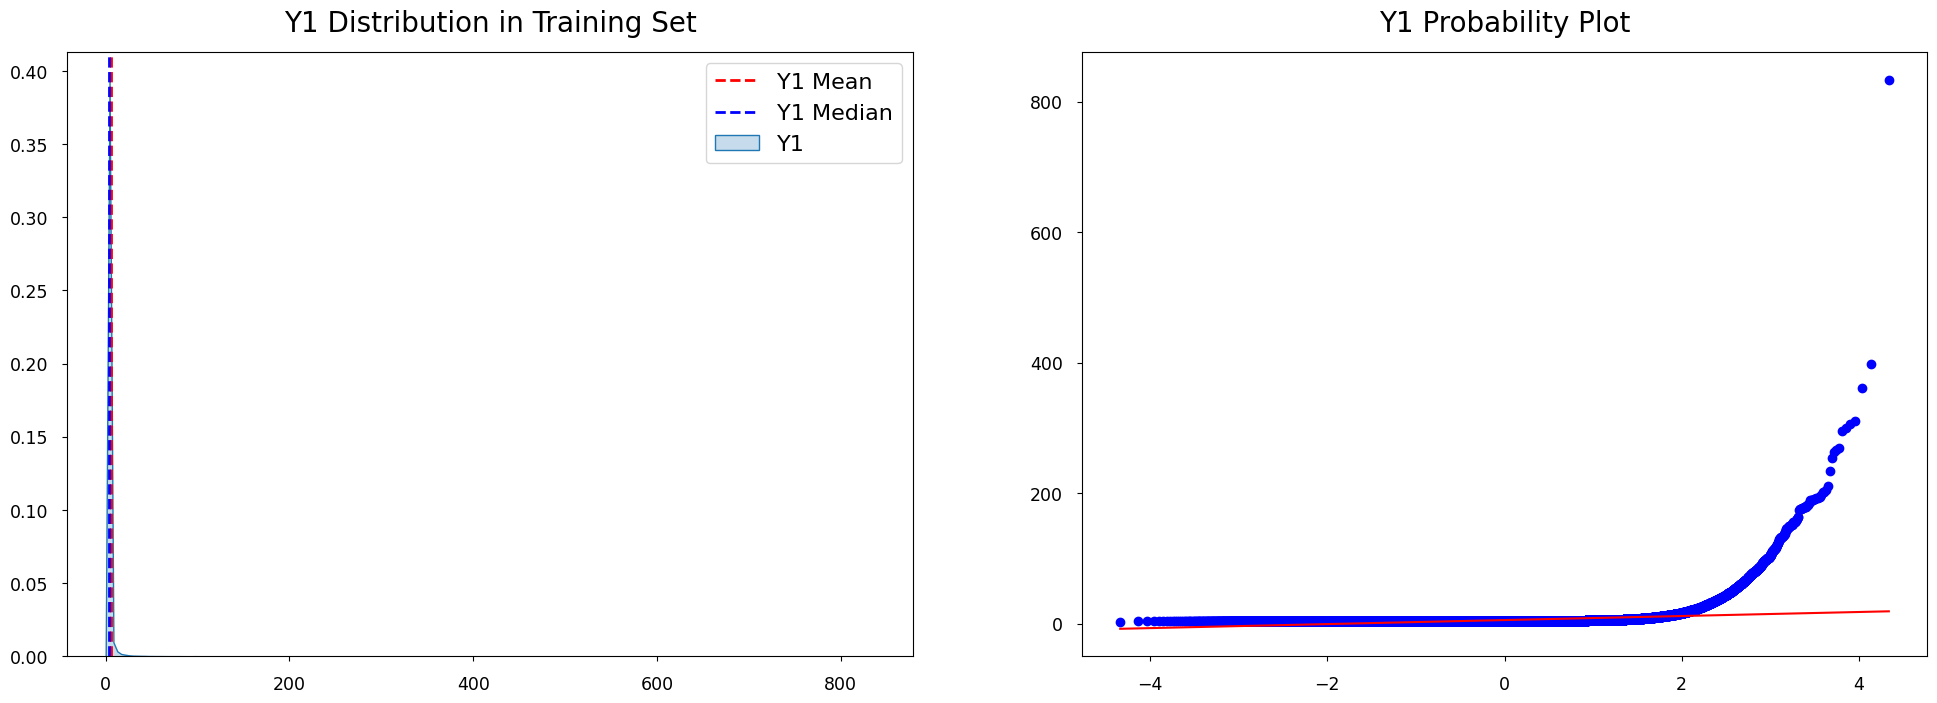

In [11]:
visualize_target('Y1')

Y2
--
Mean: 114.9807  -  Median: 27.3973  -  Std: 185.2855
Min: 0.0000  -  25%: 8.2192  -  50%: 27.3973  -  75%: 131.5068  -  Max: 1000.0000
Skew: 2.2973  -  Kurtosis: 5.0405
Missing Values: 0/96298 (0.0000%)


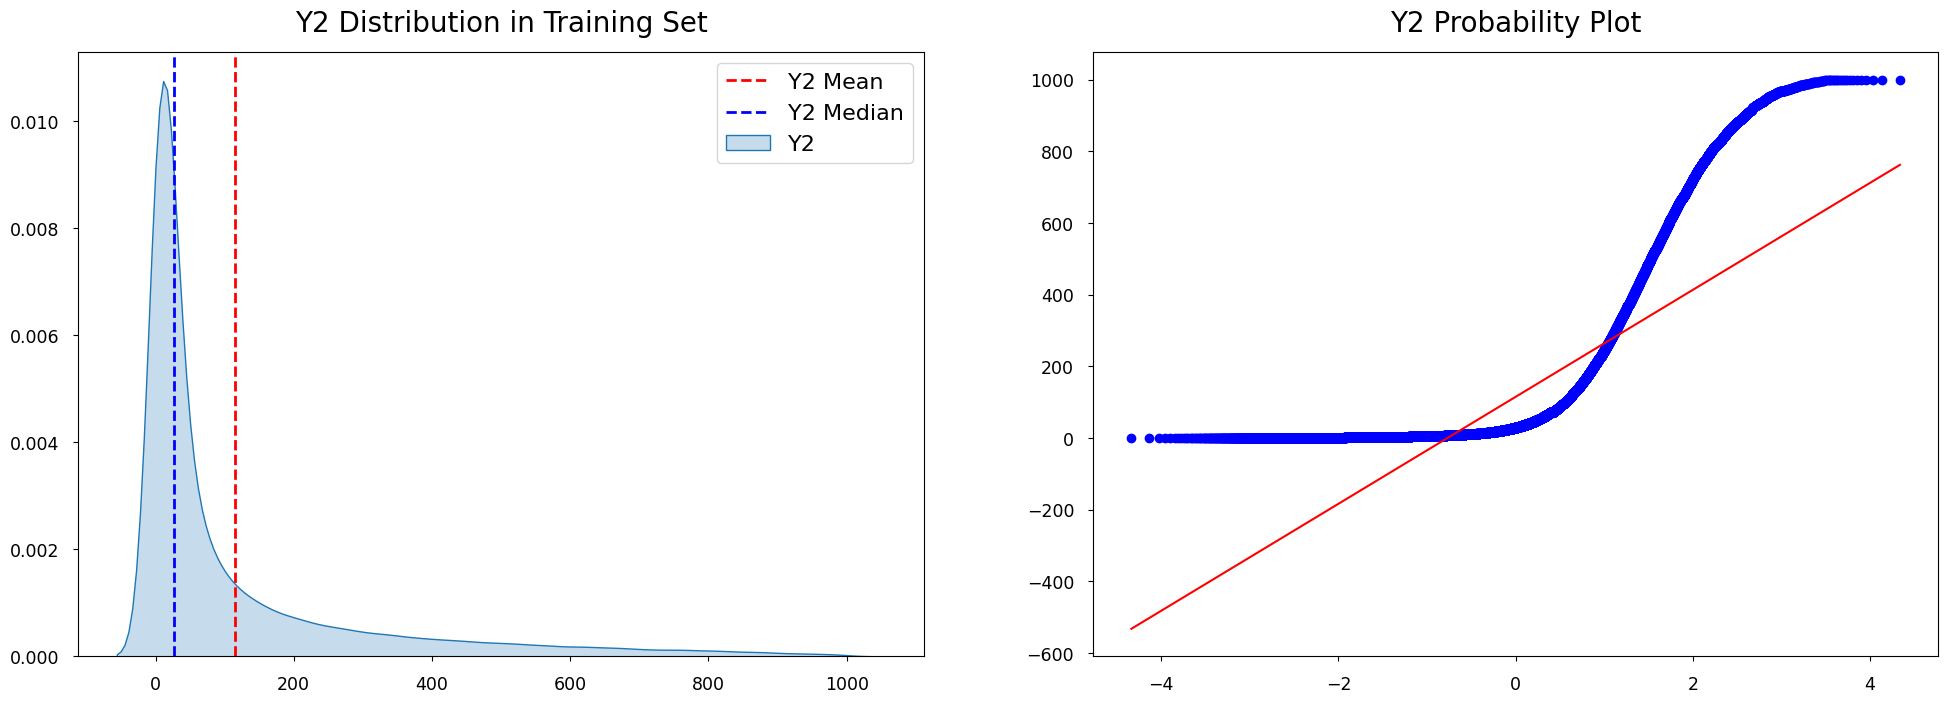

In [12]:
visualize_target('Y2')

SEQUENCE_NO
-----------
Mean: 6.9738  -  Median: 5.5000  -  Std: 5.1399
Min: 1.0000  -  25%: 2.0000  -  50%: 5.5000  -  75%: 12.0000  -  Max: 15.5000
Skew: 0.4135  -  Kurtosis: -1.3451
Missing Values: 0/96298 (0.0000%)


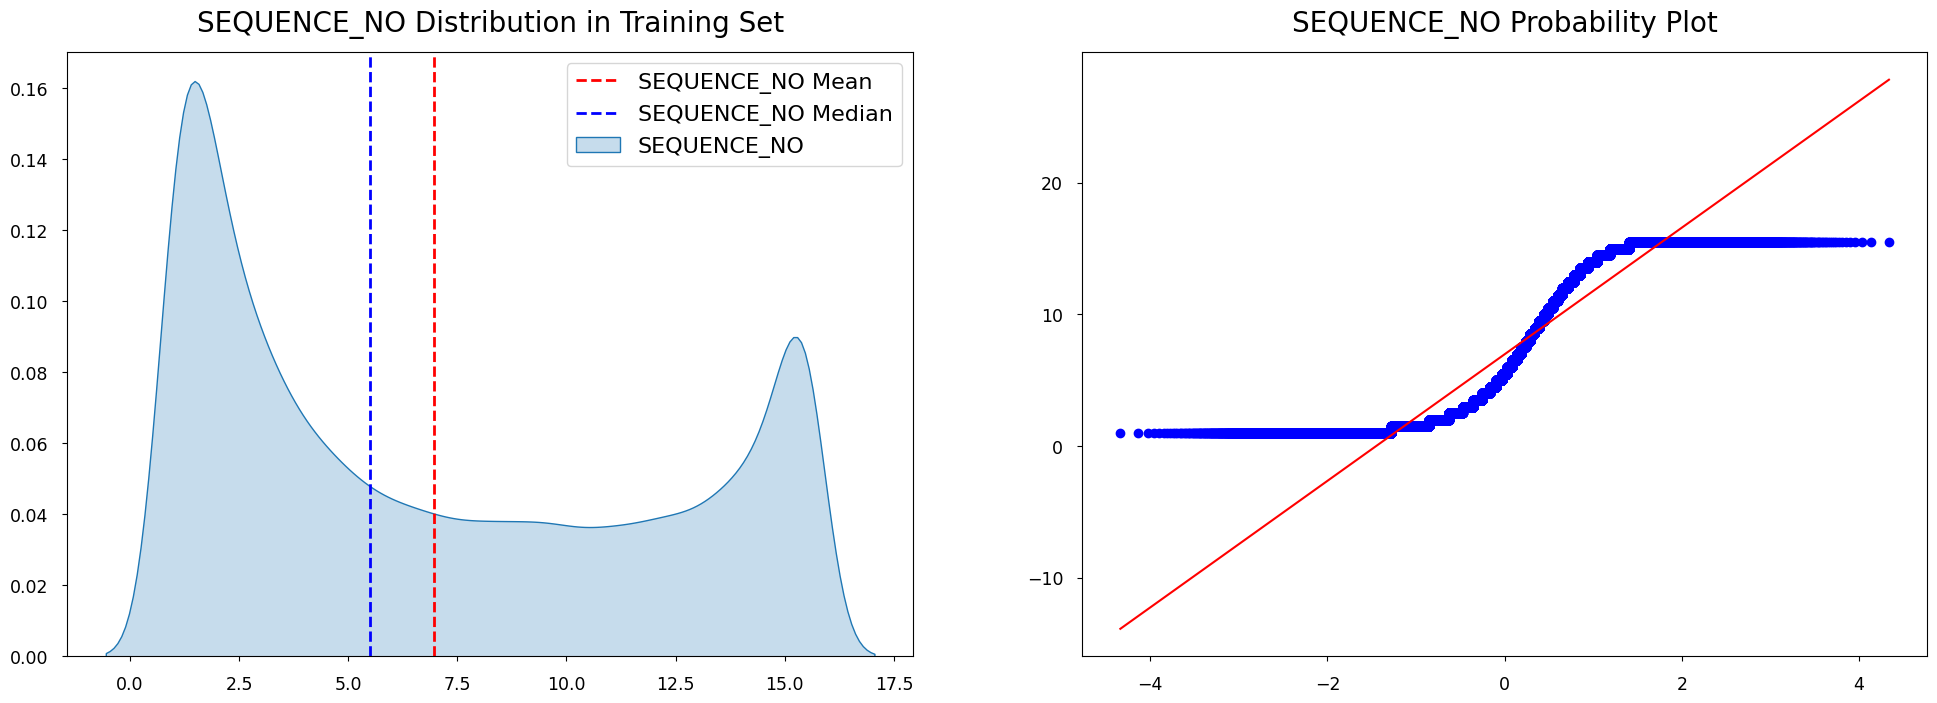

STATUS_CHECK
------------
Mean: 0.2796  -  Median: 0.0000  -  Std: 0.4488
Min: 0.0000  -  25%: 0.0000  -  50%: 0.0000  -  75%: 1.0000  -  Max: 1.0000
Skew: 0.9819  -  Kurtosis: -1.0358
Missing Values: 0/96298 (0.0000%)


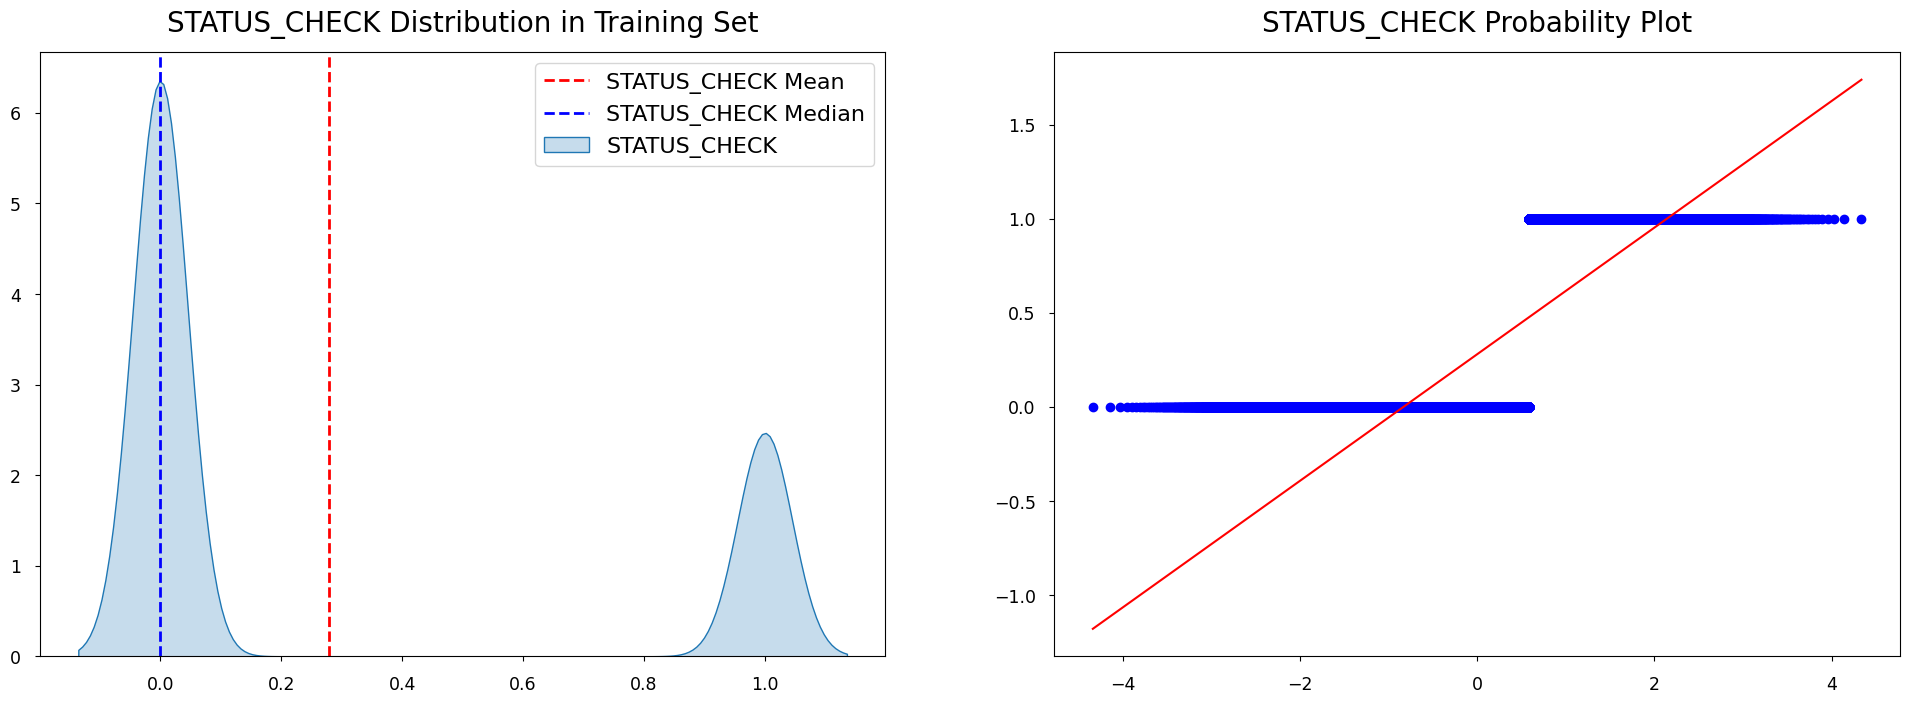

ACTIVE_YN
---------
Mean: 0.9828  -  Median: 1.0000  -  Std: 0.0686
Min: 0.0000  -  25%: 1.0000  -  50%: 1.0000  -  75%: 1.0000  -  Max: 1.0000
Skew: -6.3889  -  Kurtosis: 53.9534
Missing Values: 0/96298 (0.0000%)


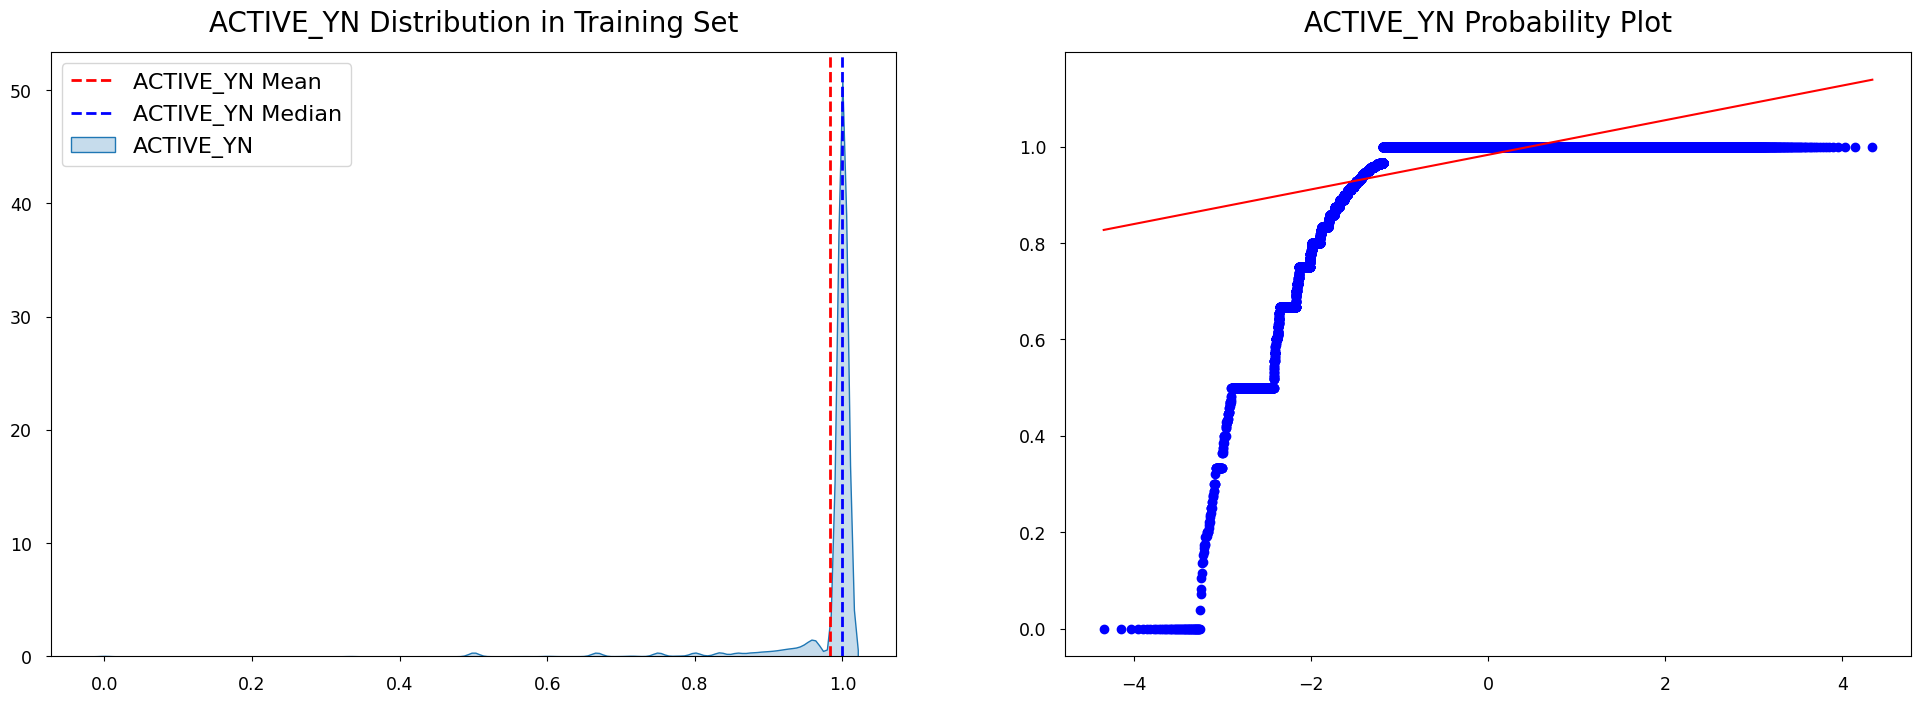

ENTRY
-----
Mean: 4.4863  -  Median: 0.7832  -  Std: 17.5866
Min: 0.0000  -  25%: 0.2729  -  50%: 0.7832  -  75%: 2.5305  -  Max: 1490.1366
Skew: 20.8410  -  Kurtosis: 998.4825
Missing Values: 0/96298 (0.0000%)


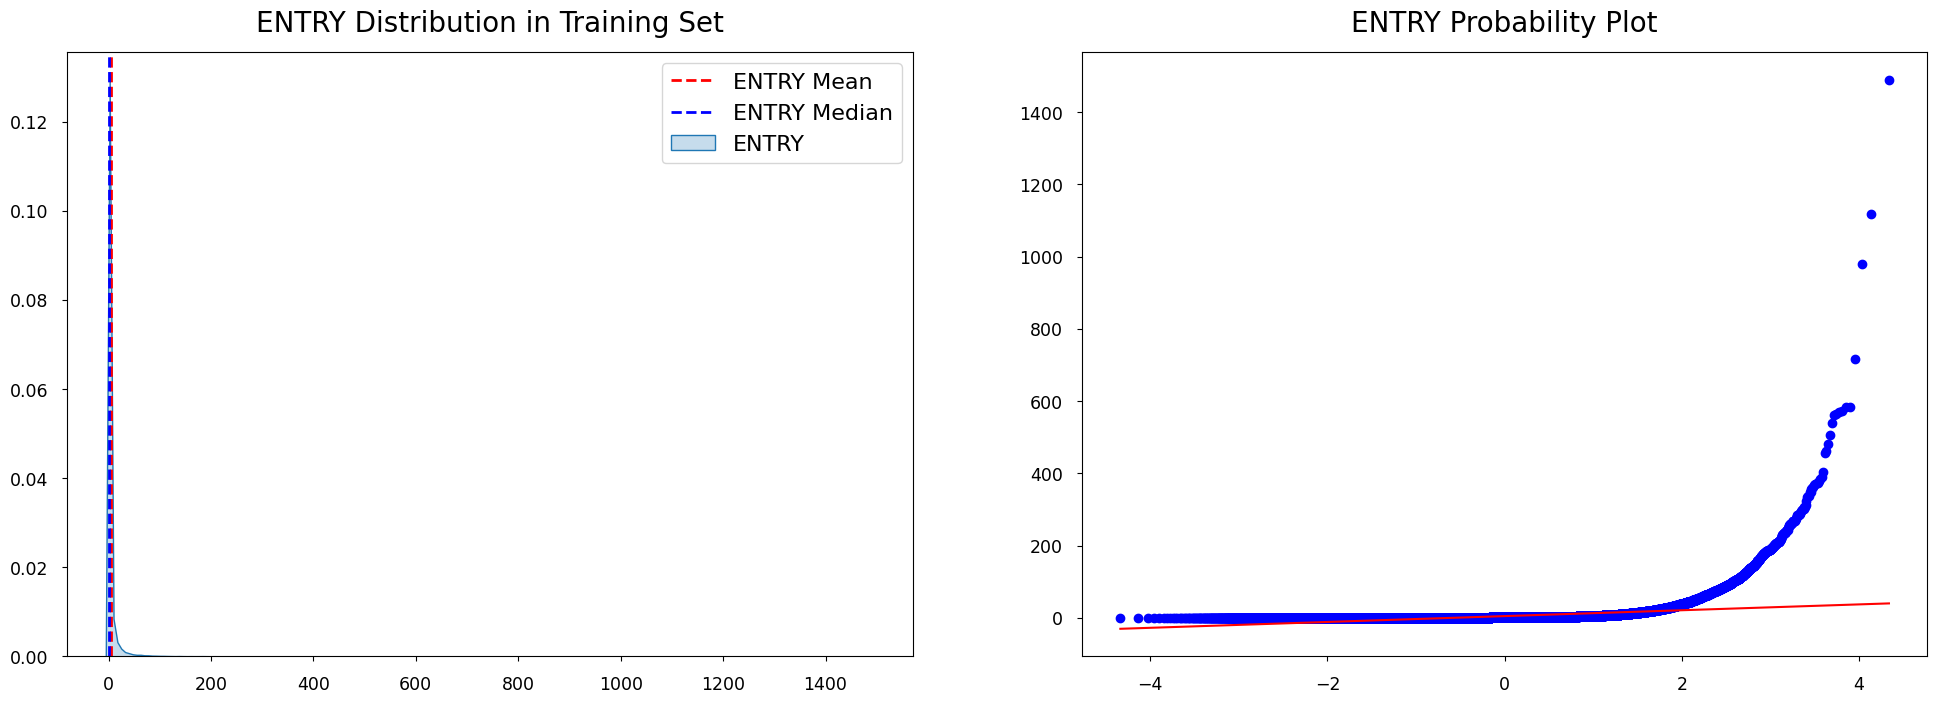

REVENUE
-------
Mean: 0.5019  -  Median: 0.1048  -  Std: 1.7264
Min: 0.0000  -  25%: 0.0360  -  50%: 0.1048  -  75%: 0.3287  -  Max: 119.3498
Skew: 17.3552  -  Kurtosis: 677.5773
Missing Values: 0/96298 (0.0000%)


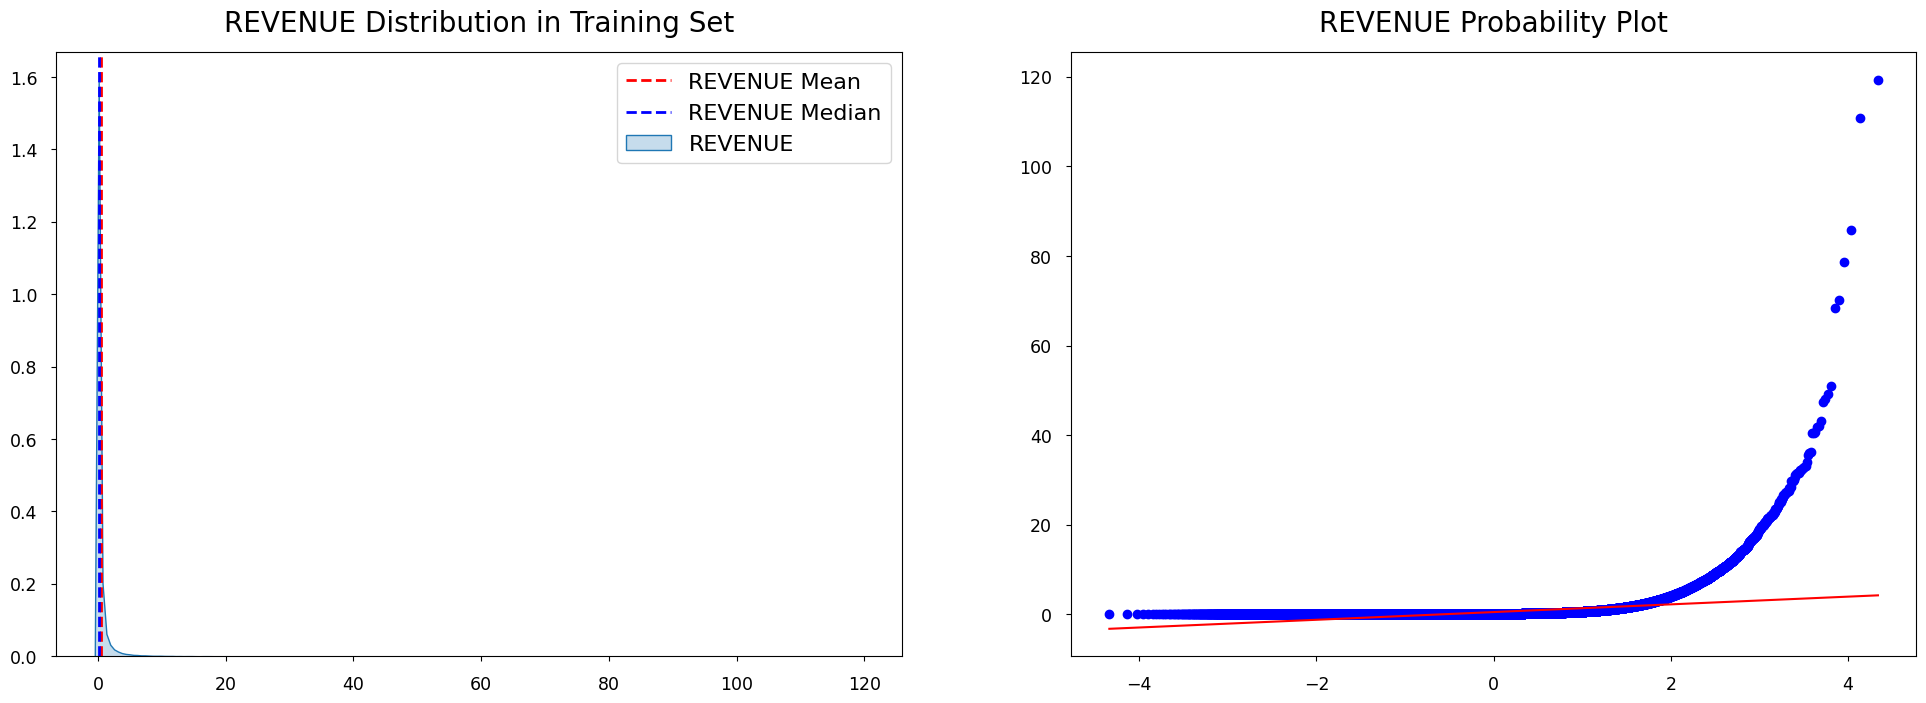

WINNINGS_1
----------
Mean: 3.3447  -  Median: 0.4685  -  Std: 14.3423
Min: 0.0000  -  25%: 0.1069  -  50%: 0.4685  -  75%: 1.7205  -  Max: 1115.2667
Skew: 21.1837  -  Kurtosis: 963.6838
Missing Values: 0/96298 (0.0000%)


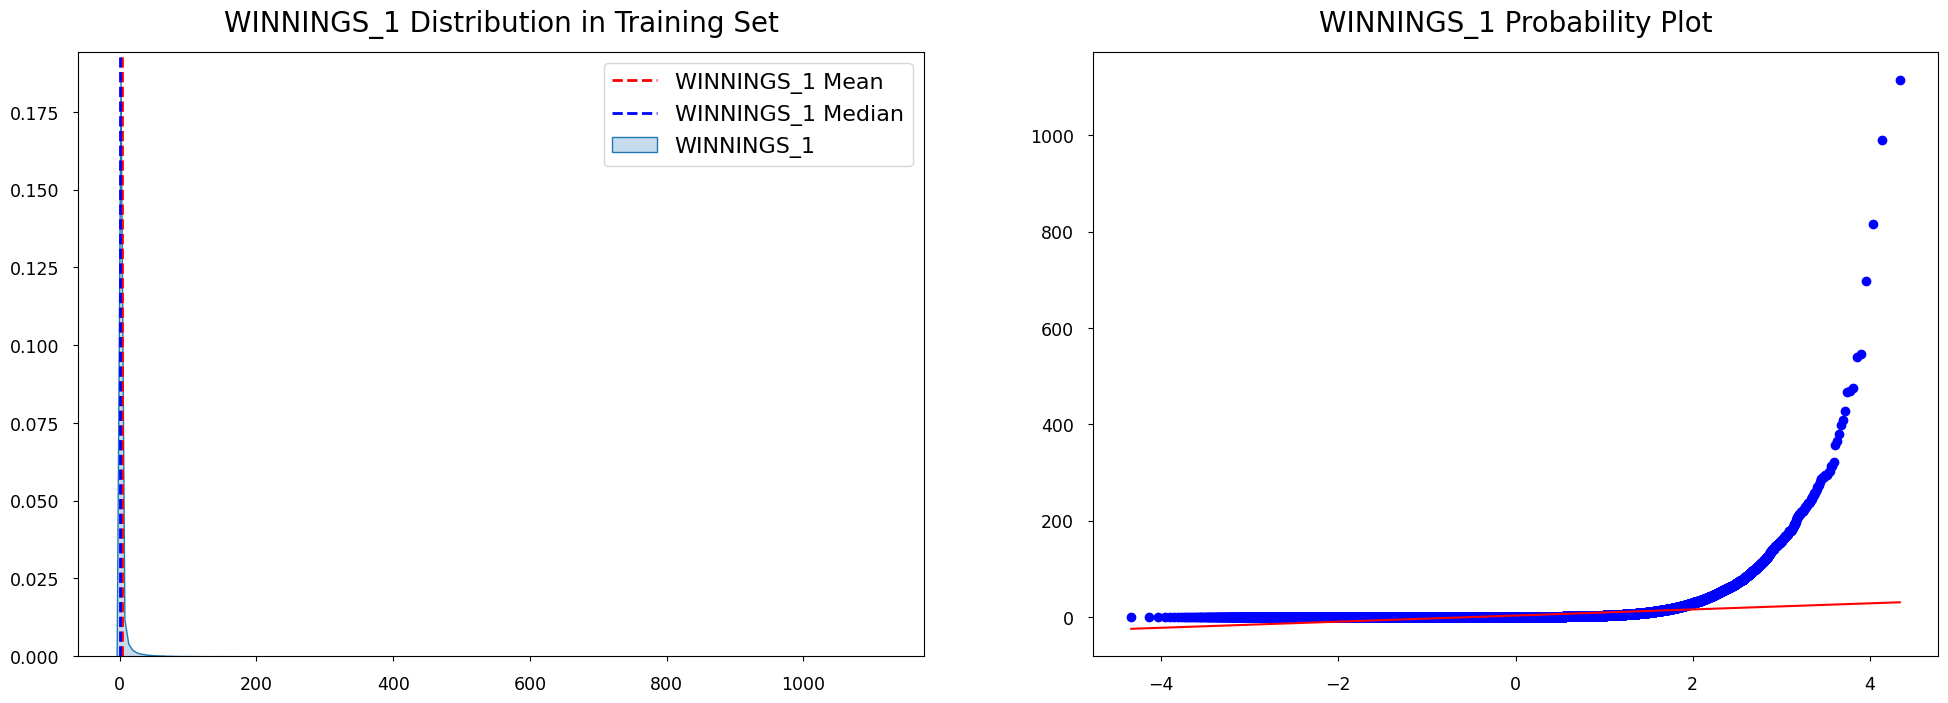

WINNINGS_2
----------
Mean: 0.0240  -  Median: 0.0000  -  Std: 0.1699
Min: 0.0000  -  25%: 0.0000  -  50%: 0.0000  -  75%: 0.0000  -  Max: 17.8767
Skew: 38.9715  -  Kurtosis: 2540.2987
Missing Values: 0/96298 (0.0000%)


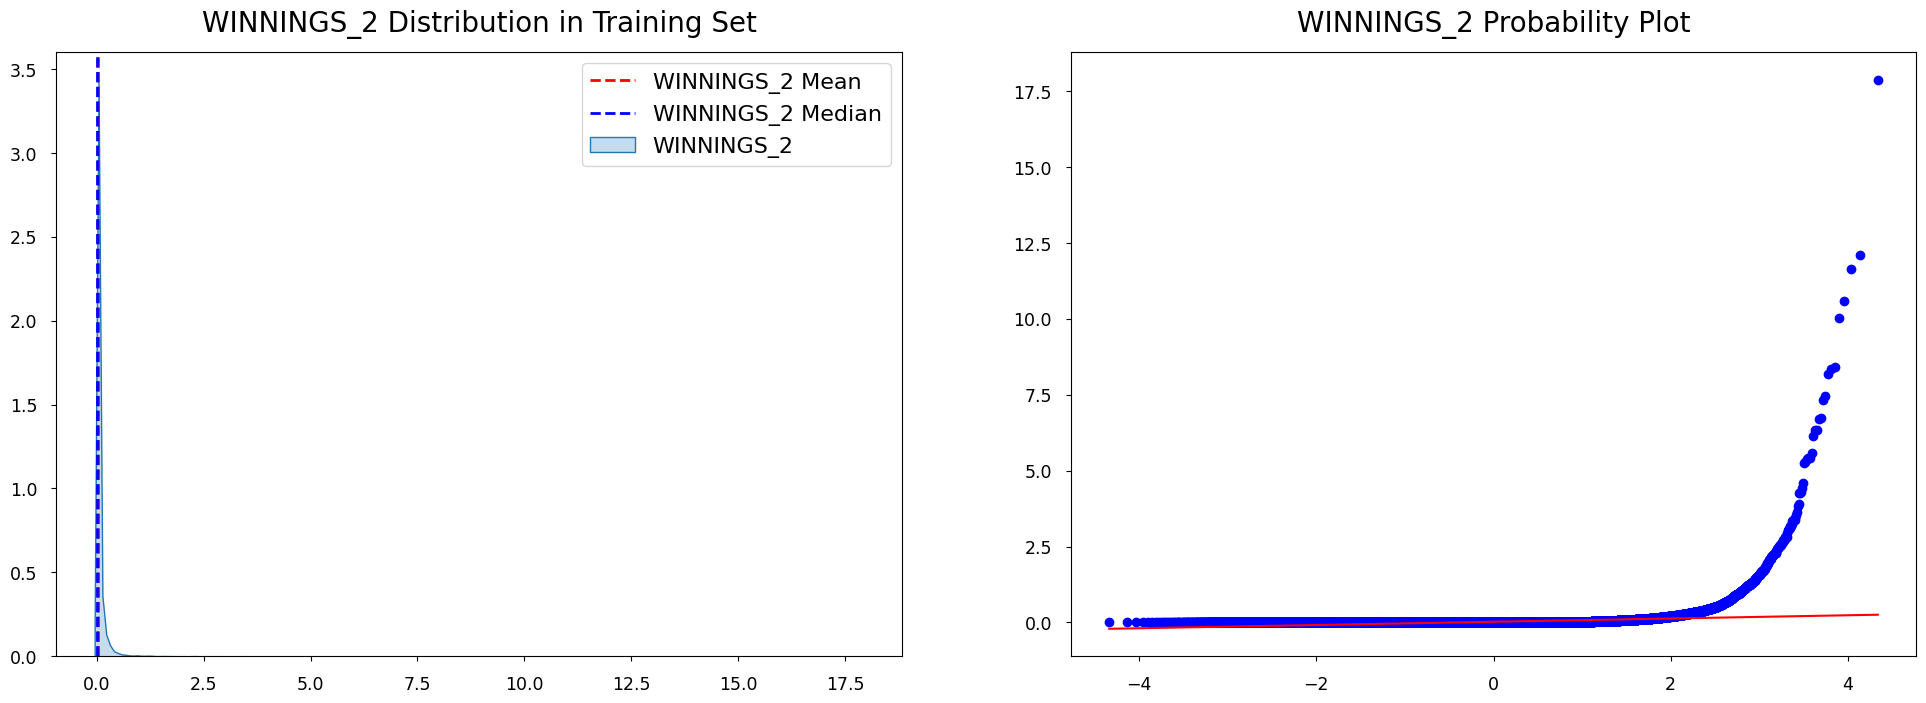

DISCOUNT
--------
Mean: 0.6456  -  Median: 0.1478  -  Std: 1.9681
Min: 0.0000  -  25%: 0.0000  -  50%: 0.1478  -  75%: 0.4612  -  Max: 58.3000
Skew: 8.7432  -  Kurtosis: 117.0927
Missing Values: 0/96298 (0.0000%)


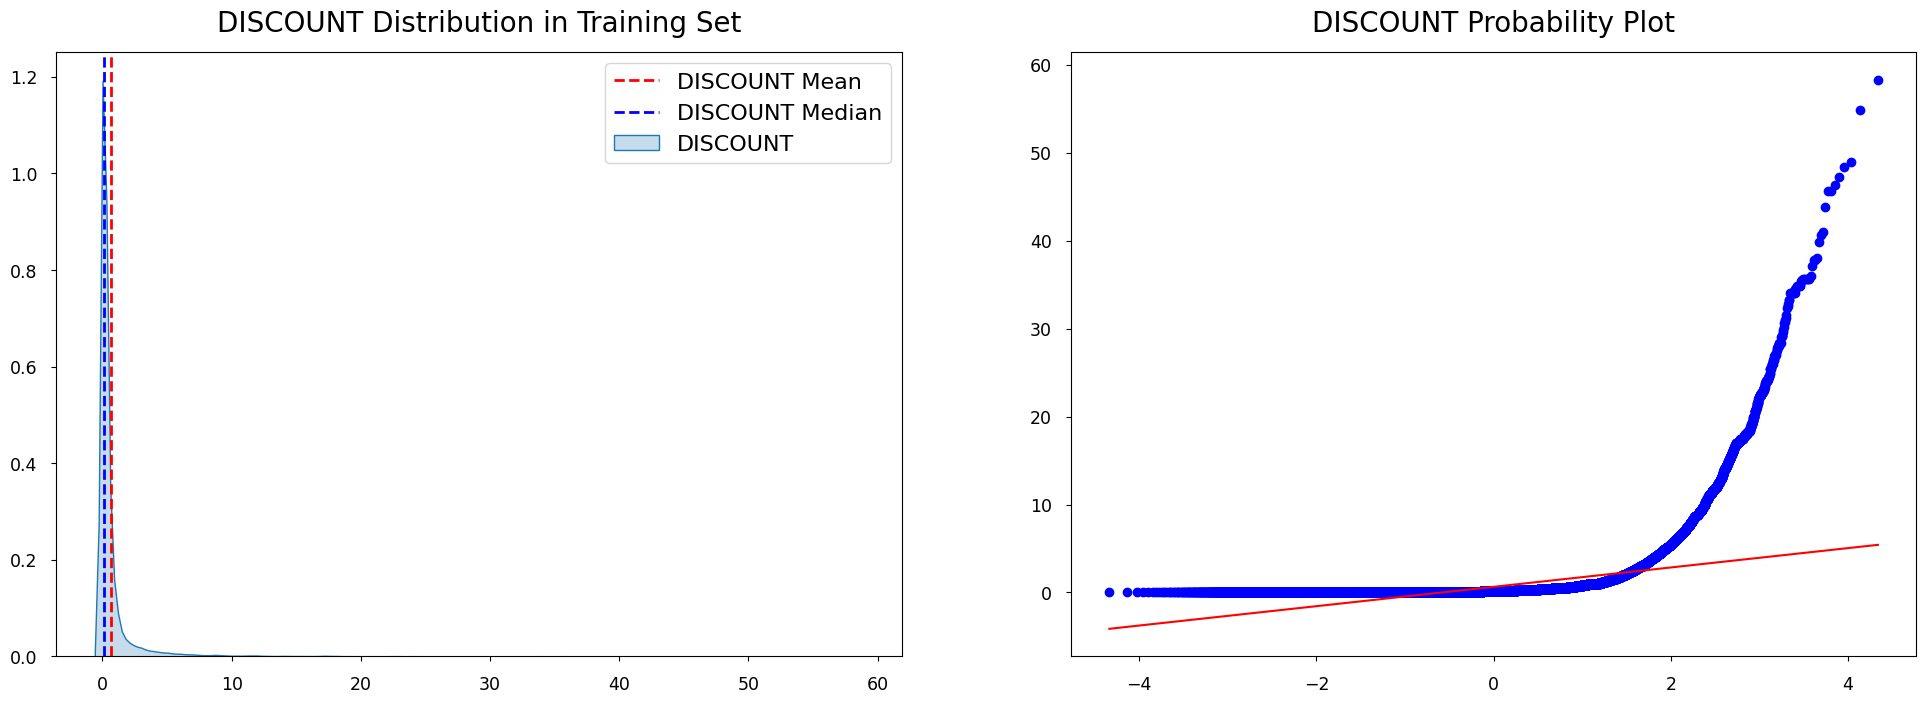

DEPOSIT
-------
Mean: 0.8393  -  Median: 0.2500  -  Std: 2.3204
Min: 0.0000  -  25%: 0.0833  -  50%: 0.2500  -  75%: 0.5588  -  Max: 75.0000
Skew: 7.8140  -  Kurtosis: 97.6814
Missing Values: 0/96298 (0.0000%)


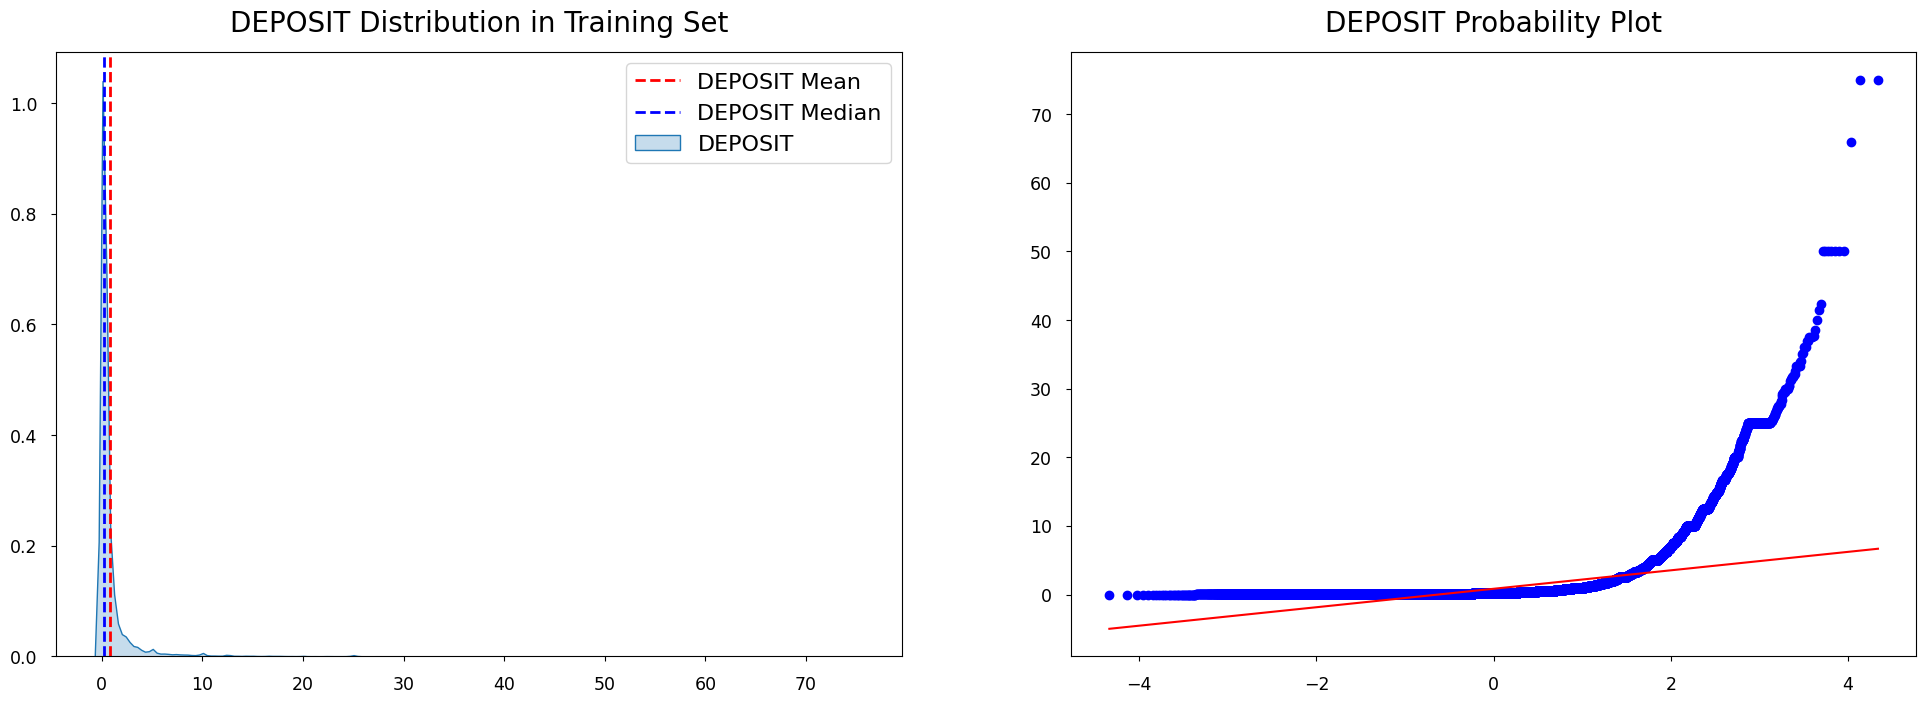

DEPOSIT_NUMBER
--------------
Mean: 0.0494  -  Median: 0.0333  -  Std: 0.0480
Min: 0.0000  -  25%: 0.0167  -  50%: 0.0333  -  75%: 0.0667  -  Max: 0.9000
Skew: 2.7790  -  Kurtosis: 16.7615
Missing Values: 0/96298 (0.0000%)


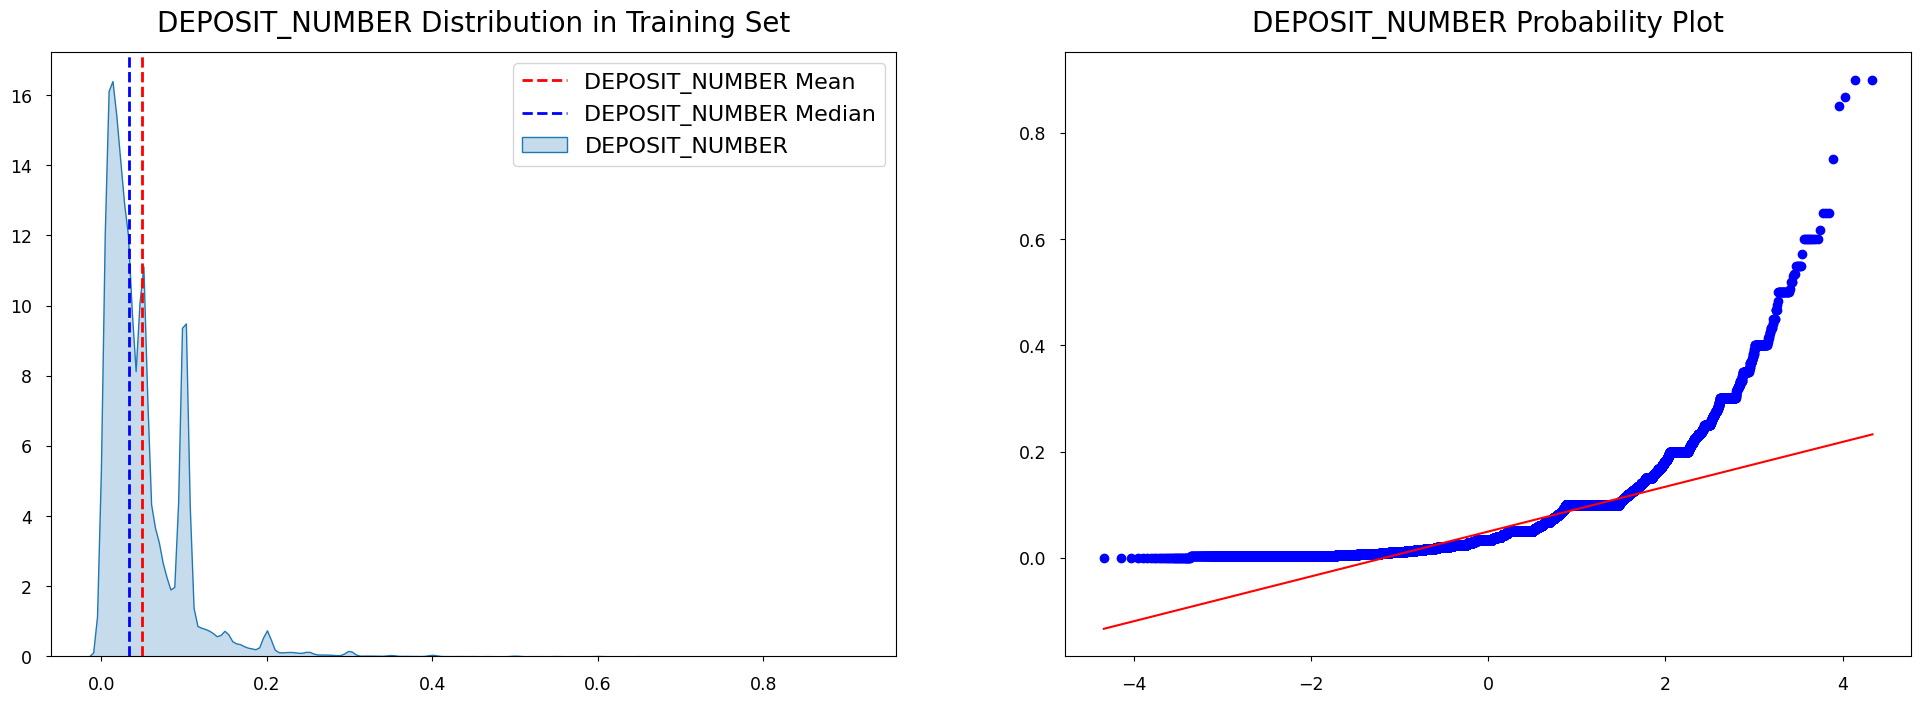

DEPOSIT_2
---------
Mean: 0.2986  -  Median: 0.0625  -  Std: 1.0589
Min: 0.0000  -  25%: 0.0227  -  50%: 0.0625  -  75%: 0.2273  -  Max: 25.0000
Skew: 11.5000  -  Kurtosis: 195.4243
Missing Values: 0/96298 (0.0000%)


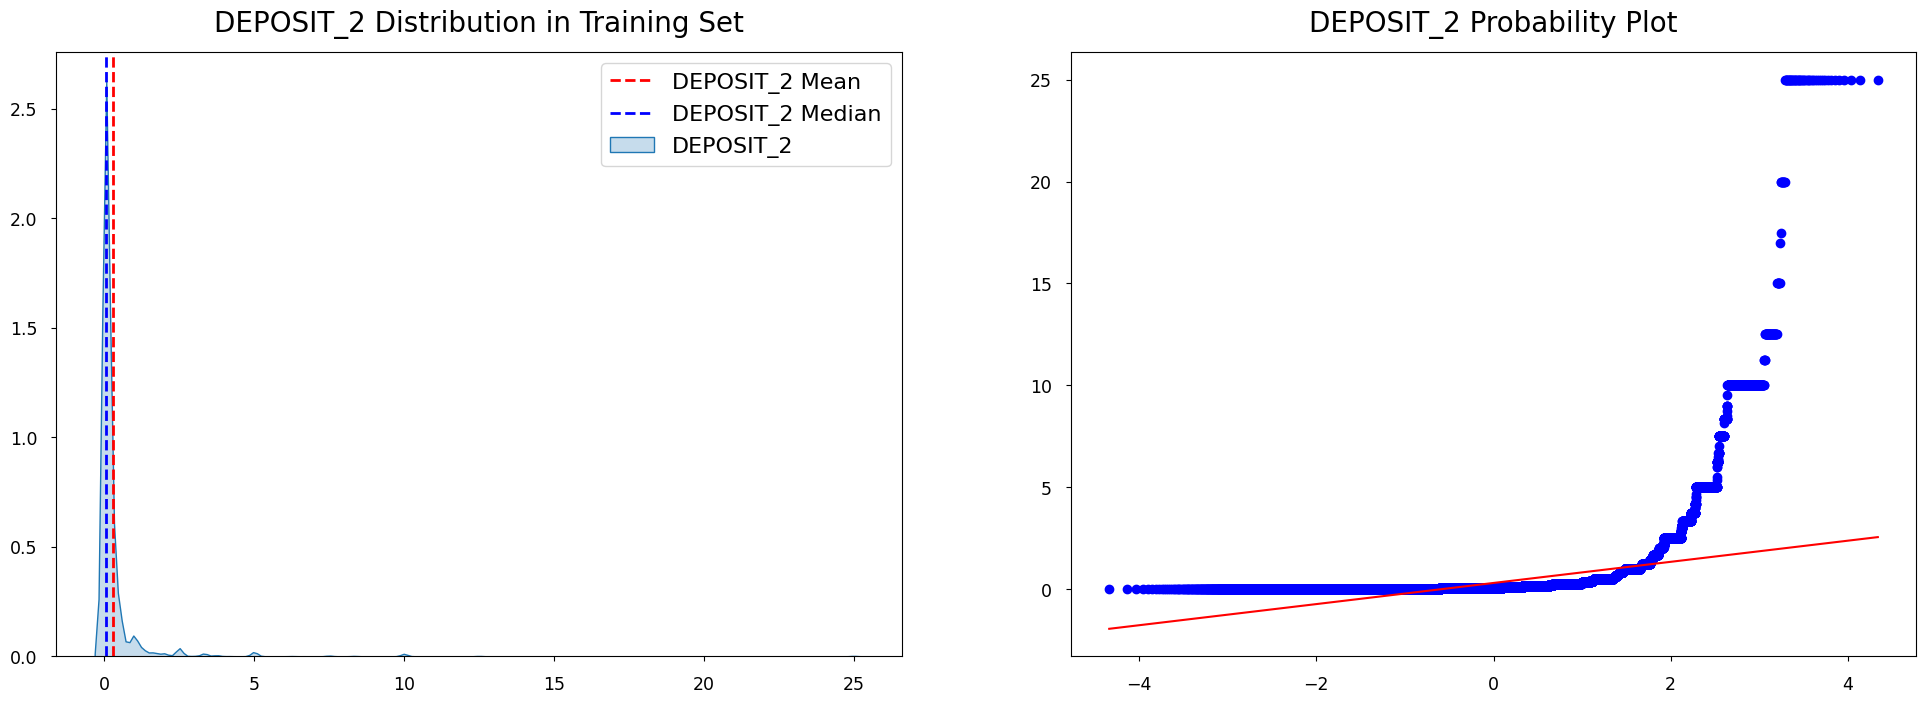

WITHDRAW
--------
Mean: 0.0460  -  Median: 0.0000  -  Std: 0.3743
Min: 0.0000  -  25%: 0.0000  -  50%: 0.0000  -  75%: 0.0000  -  Max: 31.5414
Skew: 22.9765  -  Kurtosis: 999.9791
Missing Values: 0/96298 (0.0000%)


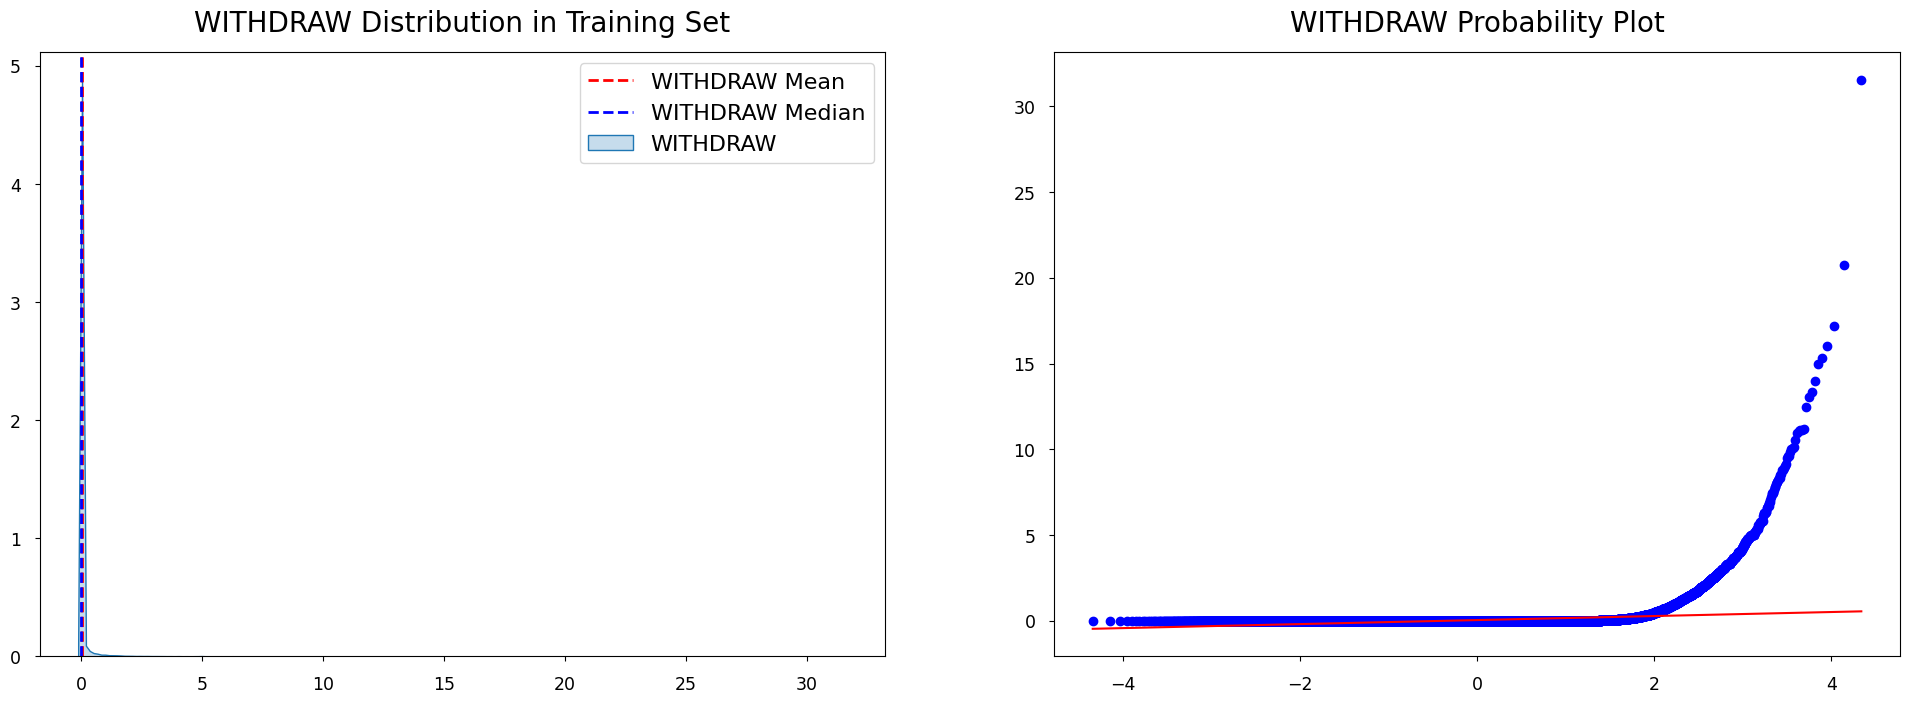

WITHDRAW_NUMBER
---------------
Mean: 0.0010  -  Median: 0.0000  -  Std: 0.0046
Min: 0.0000  -  25%: 0.0000  -  50%: 0.0000  -  75%: 0.0000  -  Max: 0.1267
Skew: 7.4962  -  Kurtosis: 86.2495
Missing Values: 0/96298 (0.0000%)


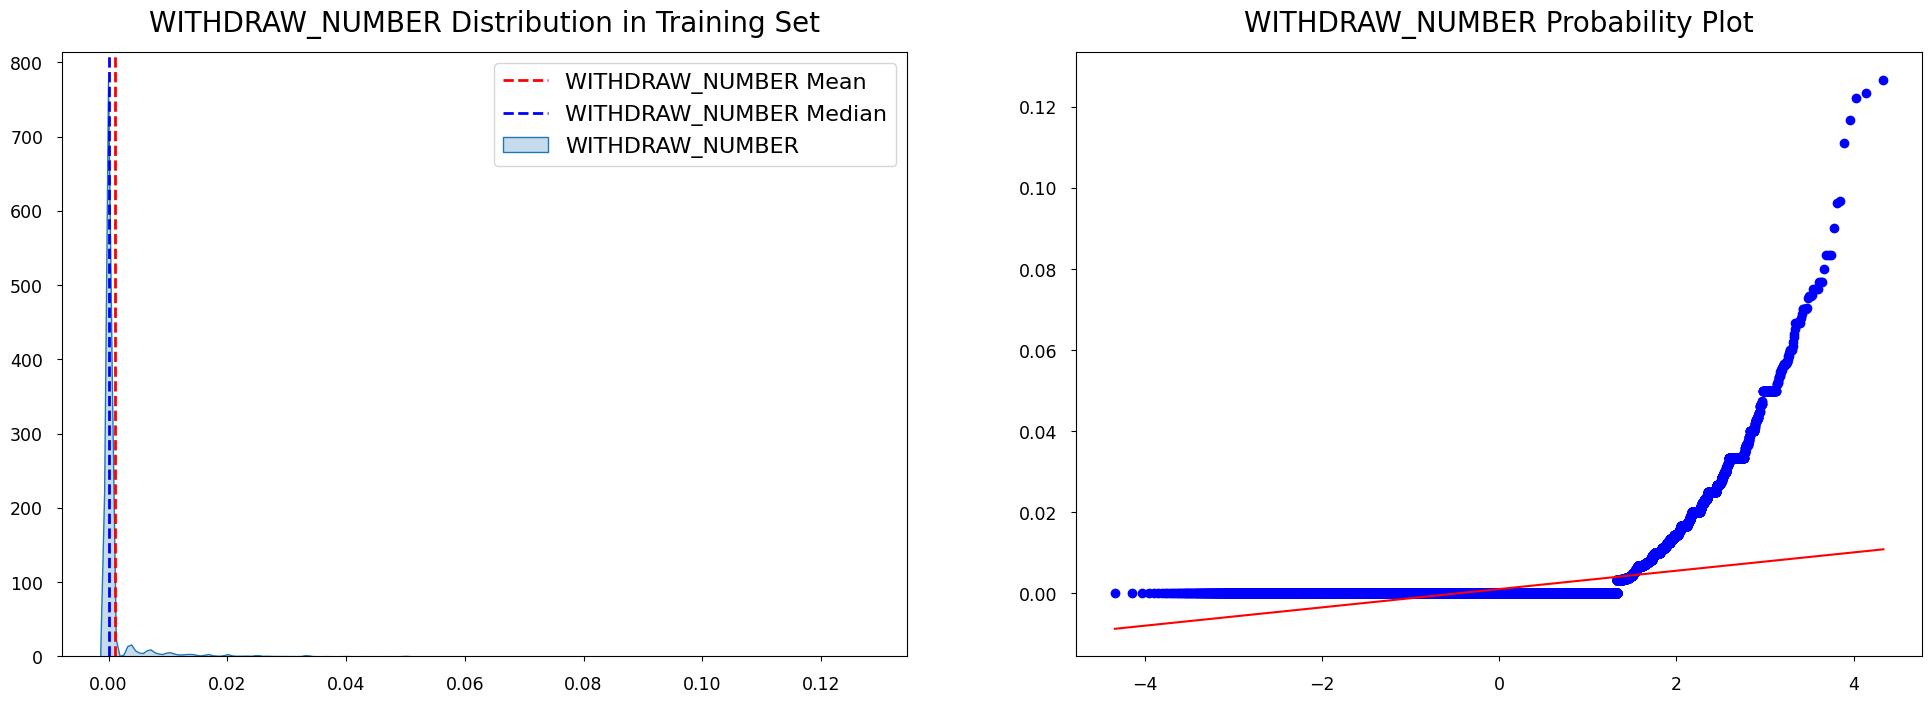

DEPOSIT_TRAILS
--------------
Mean: 0.1532  -  Median: 0.0250  -  Std: 0.5400
Min: 0.0000  -  25%: 0.0000  -  50%: 0.0250  -  75%: 0.1136  -  Max: 48.9120
Skew: 19.5129  -  Kurtosis: 953.5367
Missing Values: 0/96298 (0.0000%)


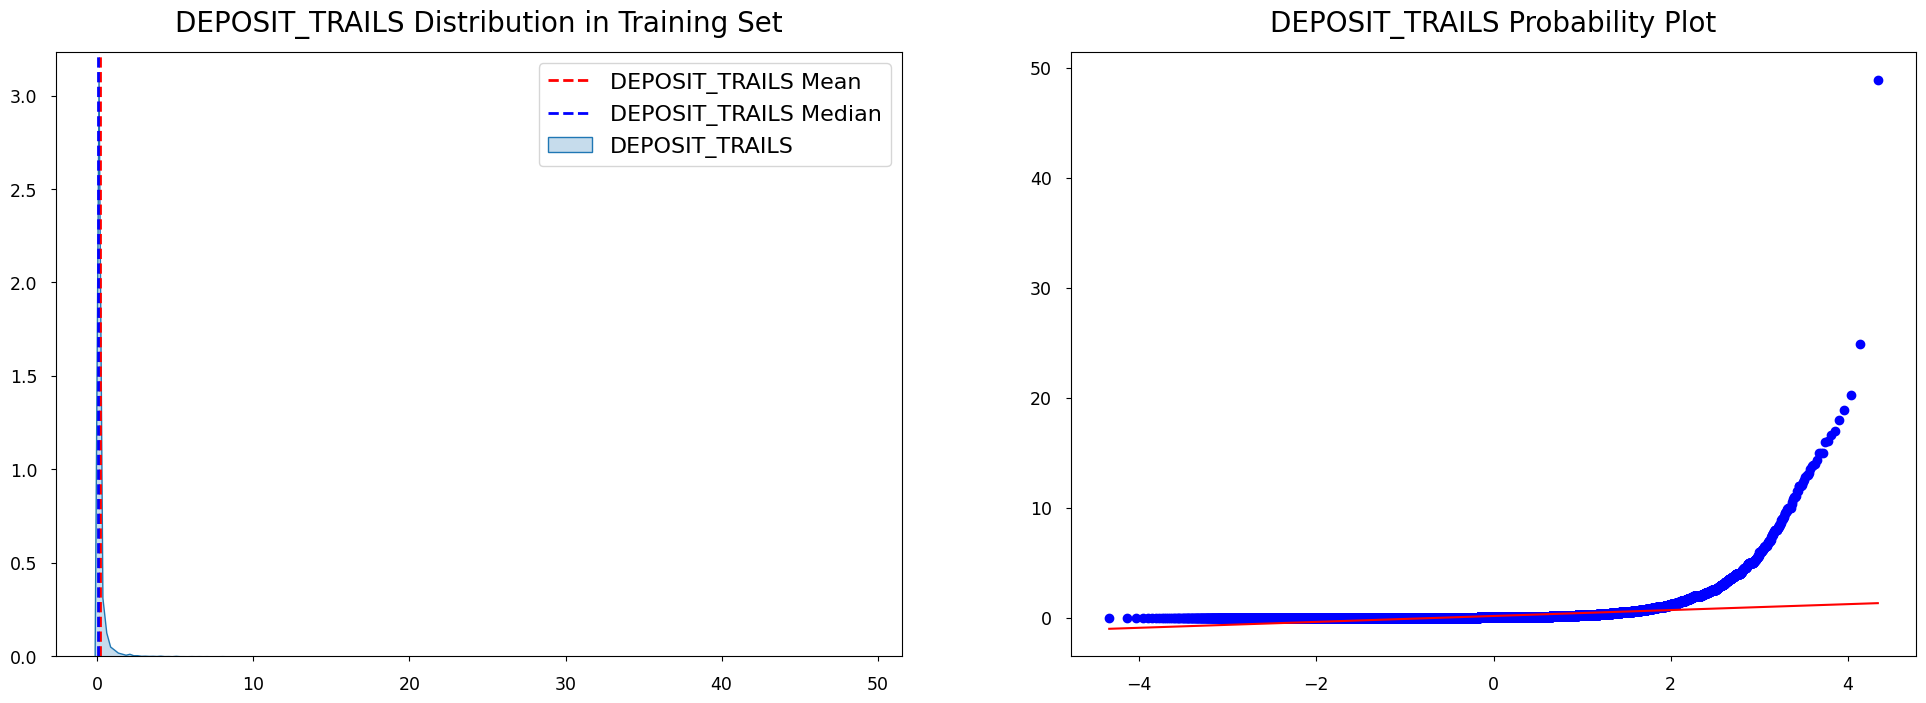

ENTRY_NUMBER
------------
Mean: 1.9007  -  Median: 1.0000  -  Std: 2.6142
Min: 0.0000  -  25%: 0.4542  -  50%: 1.0000  -  75%: 2.2074  -  Max: 60.1667
Skew: 3.6504  -  Kurtosis: 22.3210
Missing Values: 0/96298 (0.0000%)


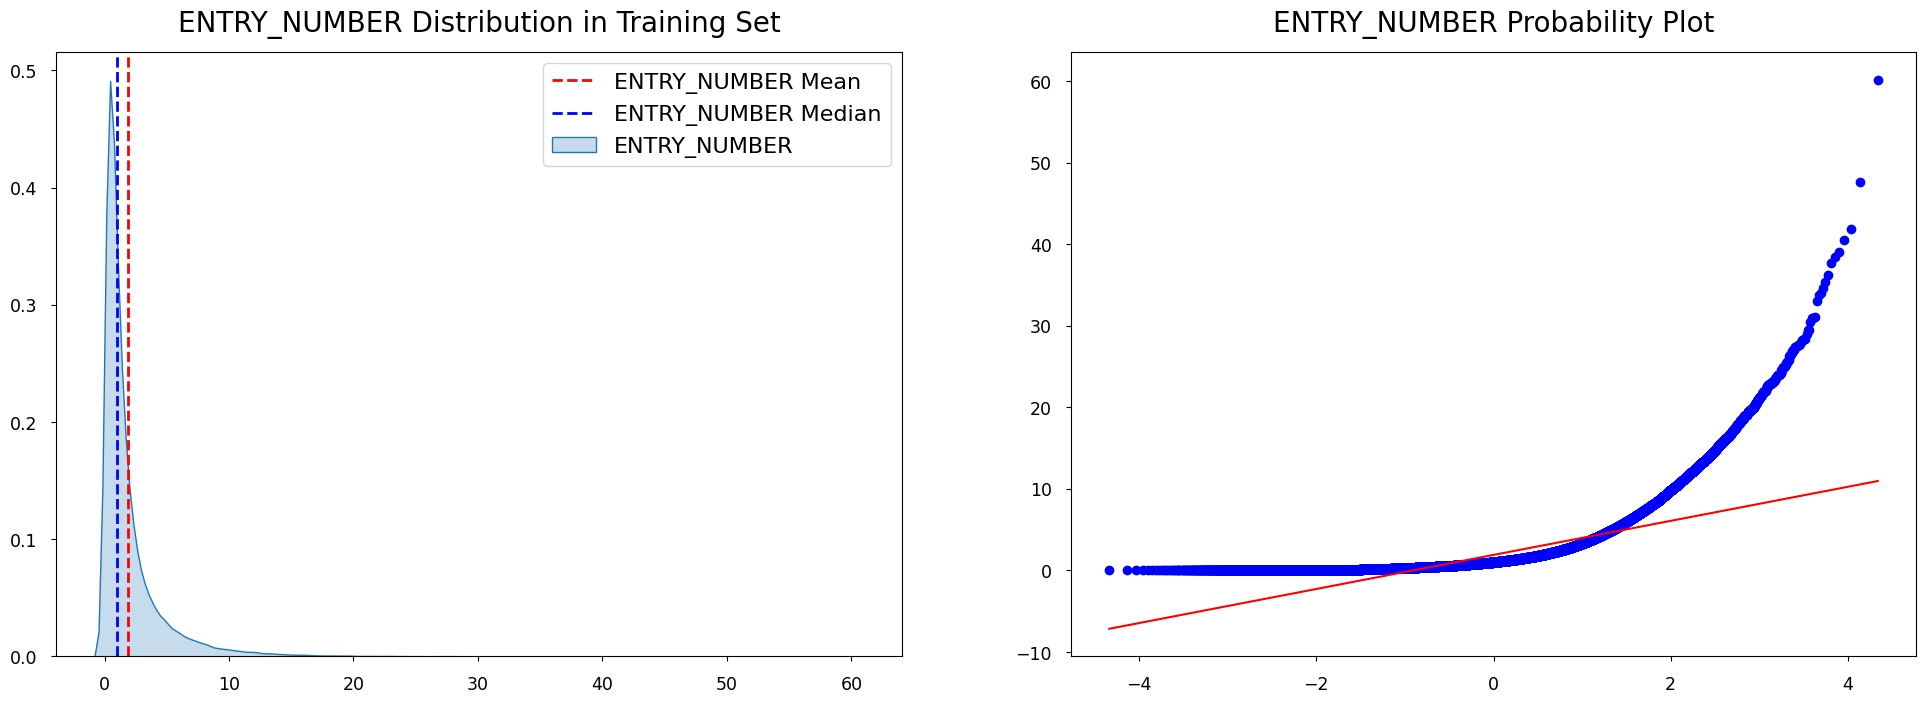

WINNINGS_NUMBER
---------------
Mean: 0.6209  -  Median: 0.3160  -  Std: 0.9421
Min: 0.0000  -  25%: 0.1115  -  50%: 0.3160  -  75%: 0.7333  -  Max: 19.1000
Skew: 4.3195  -  Kurtosis: 30.7891
Missing Values: 0/96298 (0.0000%)


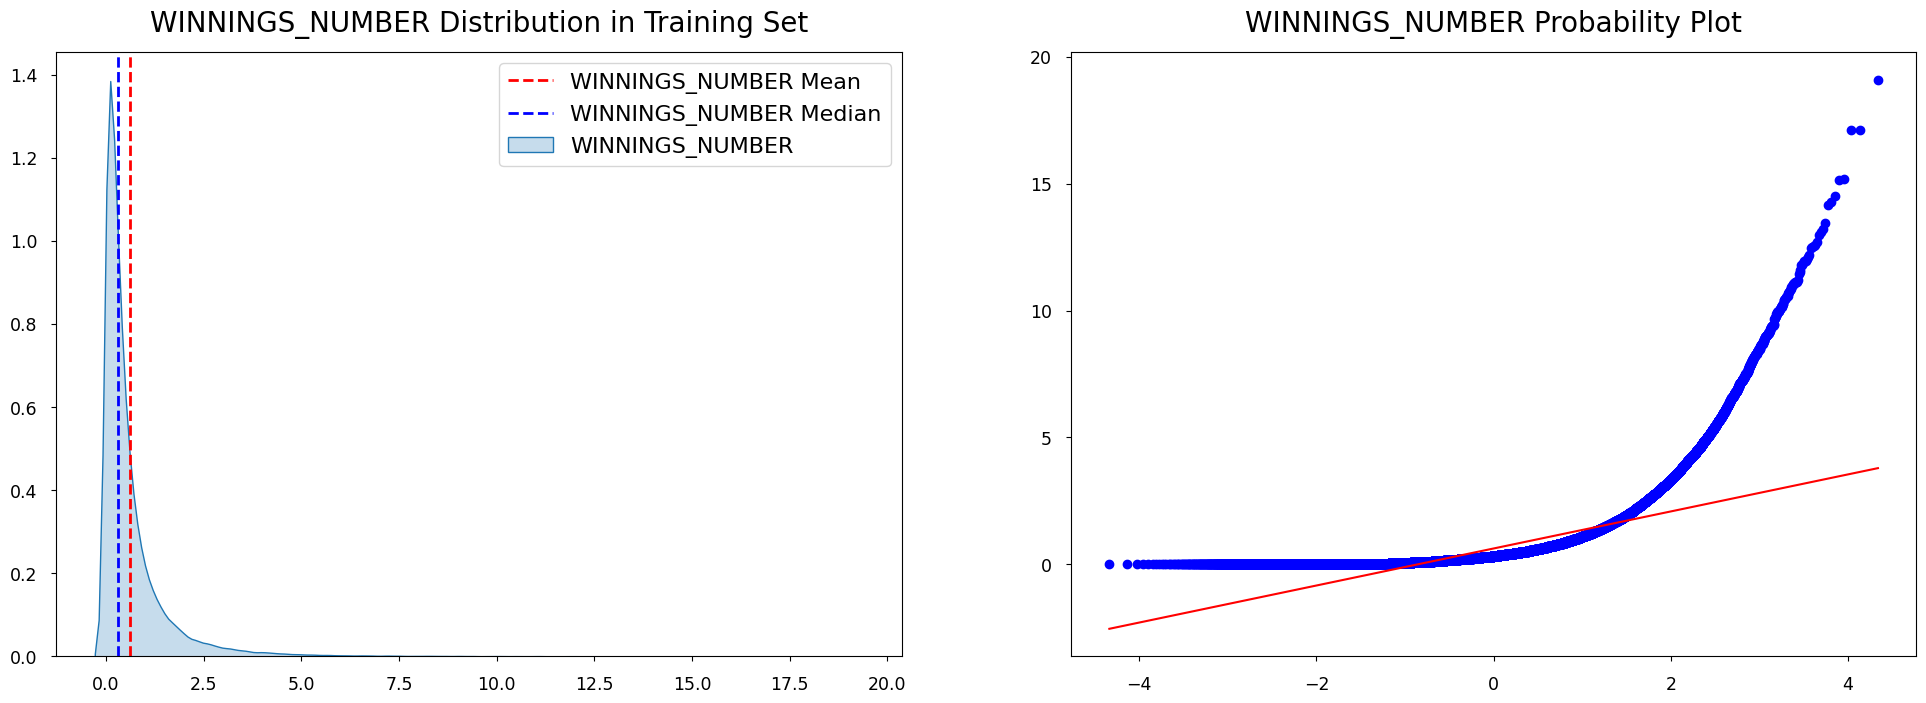

PRACTICE_ENTRY
--------------
Mean: 0.2244  -  Median: 0.0000  -  Std: 2.4452
Min: 0.0000  -  25%: 0.0000  -  50%: 0.0000  -  75%: 0.0000  -  Max: 171.5043
Skew: 25.2047  -  Kurtosis: 930.8059
Missing Values: 0/96298 (0.0000%)


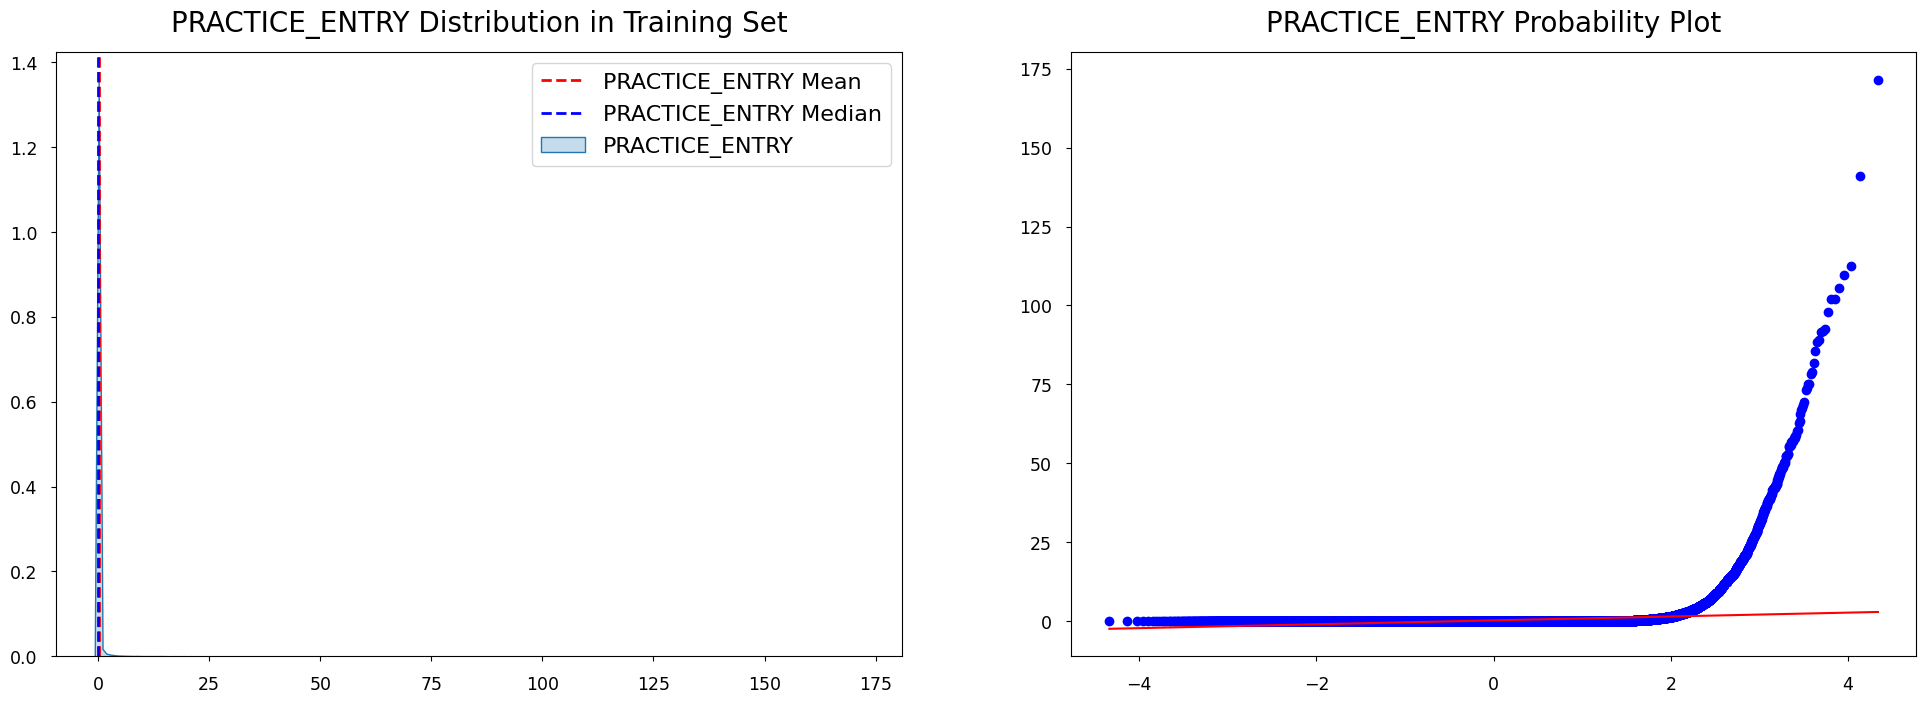

PRACTICE_WINNINGS
-----------------
Mean: 0.1755  -  Median: 0.0000  -  Std: 2.0992
Min: 0.0000  -  25%: 0.0000  -  50%: 0.0000  -  75%: 0.0000  -  Max: 165.5908
Skew: 28.3054  -  Kurtosis: 1202.2395
Missing Values: 0/96298 (0.0000%)


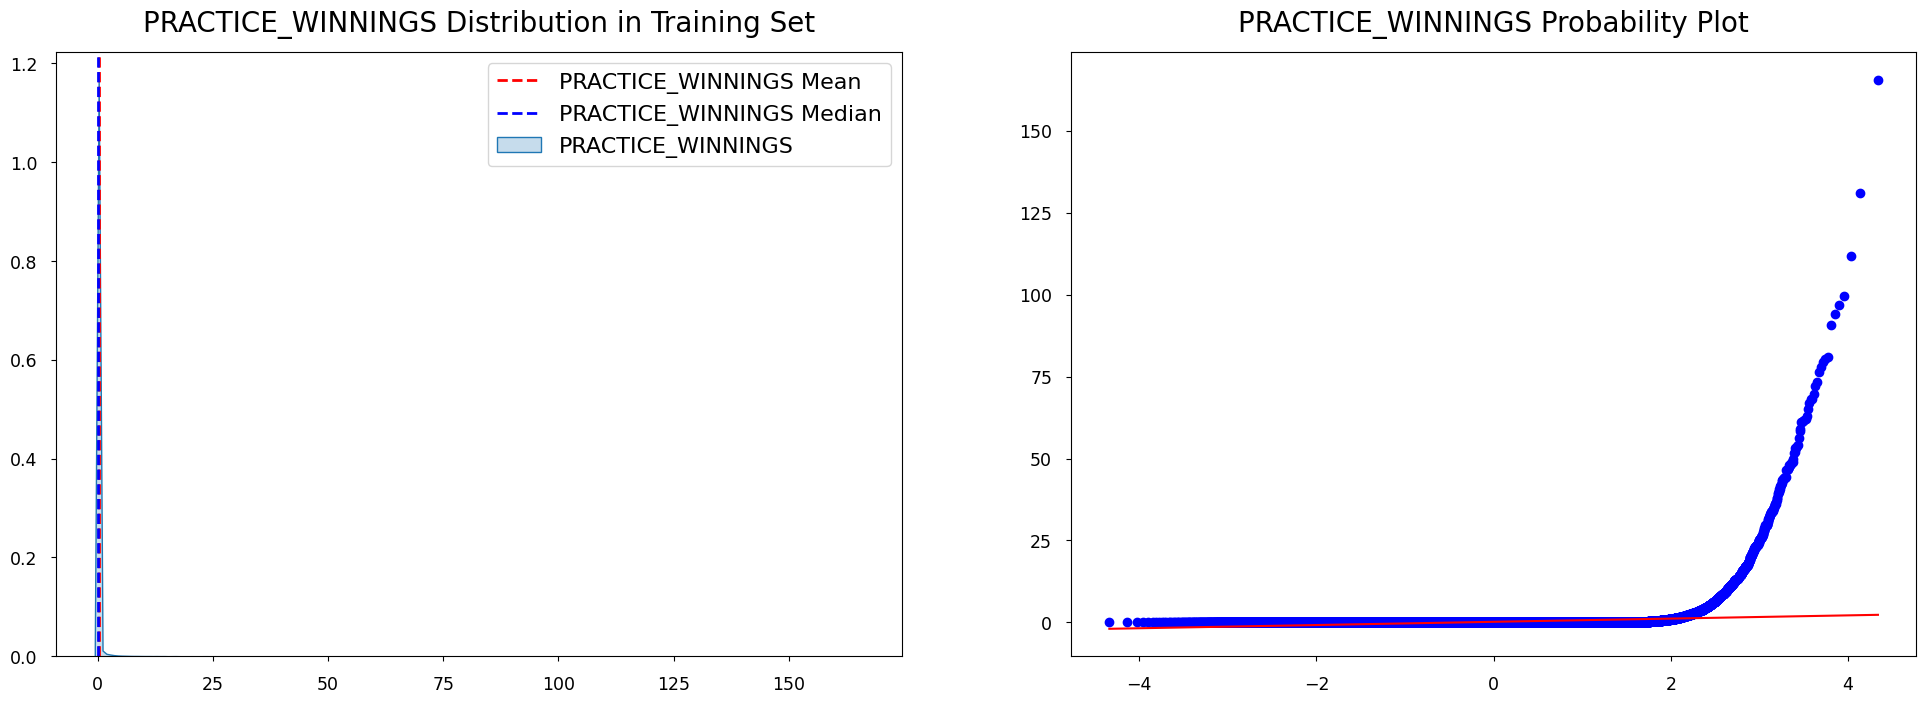

PRACTICE_ENTRY_NUMBER
---------------------
Mean: 0.0311  -  Median: 0.0000  -  Std: 0.2448
Min: 0.0000  -  25%: 0.0000  -  50%: 0.0000  -  75%: 0.0000  -  Max: 12.6133
Skew: 17.7795  -  Kurtosis: 466.2290
Missing Values: 0/96298 (0.0000%)


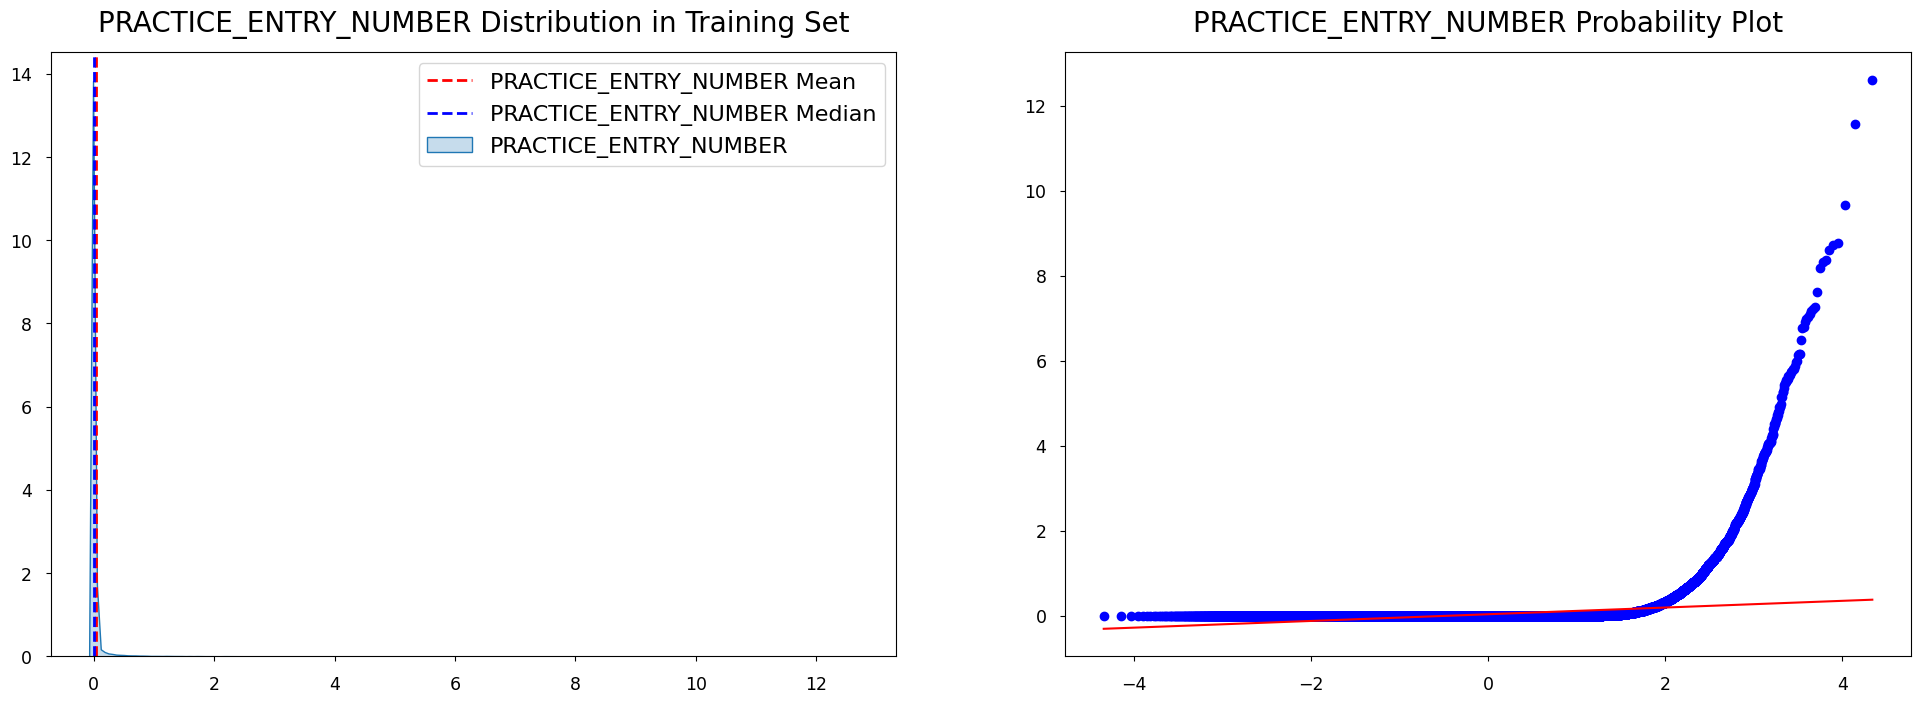

PRACTICE_WINNINGS_NUMBER
------------------------
Mean: 0.0126  -  Median: 0.0000  -  Std: 0.1060
Min: 0.0000  -  25%: 0.0000  -  50%: 0.0000  -  75%: 0.0000  -  Max: 6.5680
Skew: 20.1349  -  Kurtosis: 654.6648
Missing Values: 0/96298 (0.0000%)


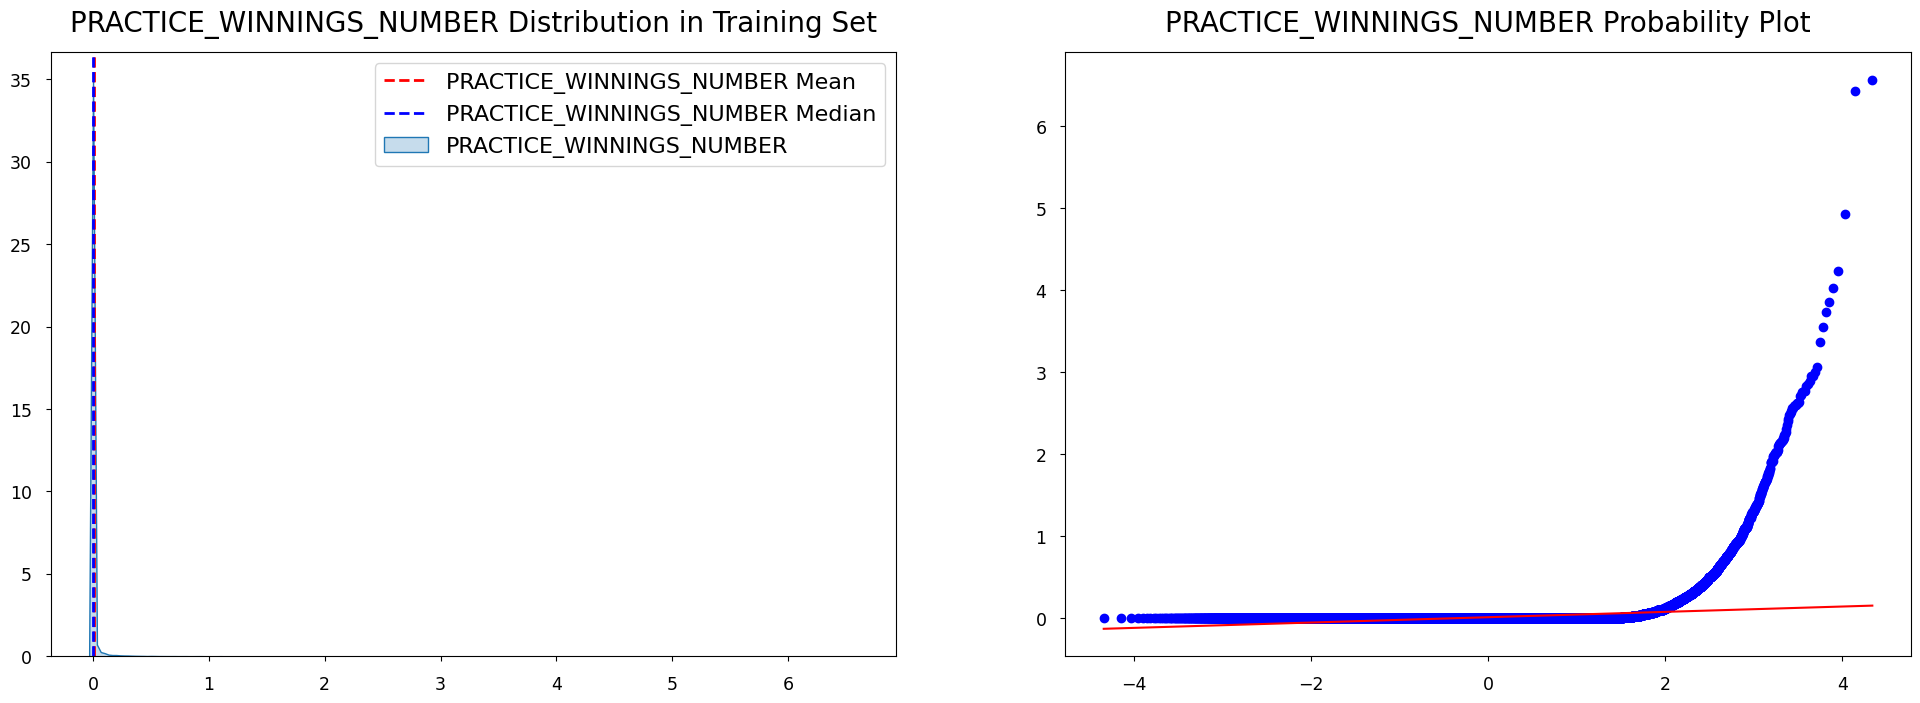

Y1
--
Mean: 5.3640  -  Median: 4.0189  -  Std: 8.4392
Min: 2.6041  -  25%: 3.9841  -  50%: 4.0189  -  75%: 4.3328  -  Max: 834.0632
Skew: 23.7719  -  Kurtosis: 1290.6972
Missing Values: 0/96298 (0.0000%)


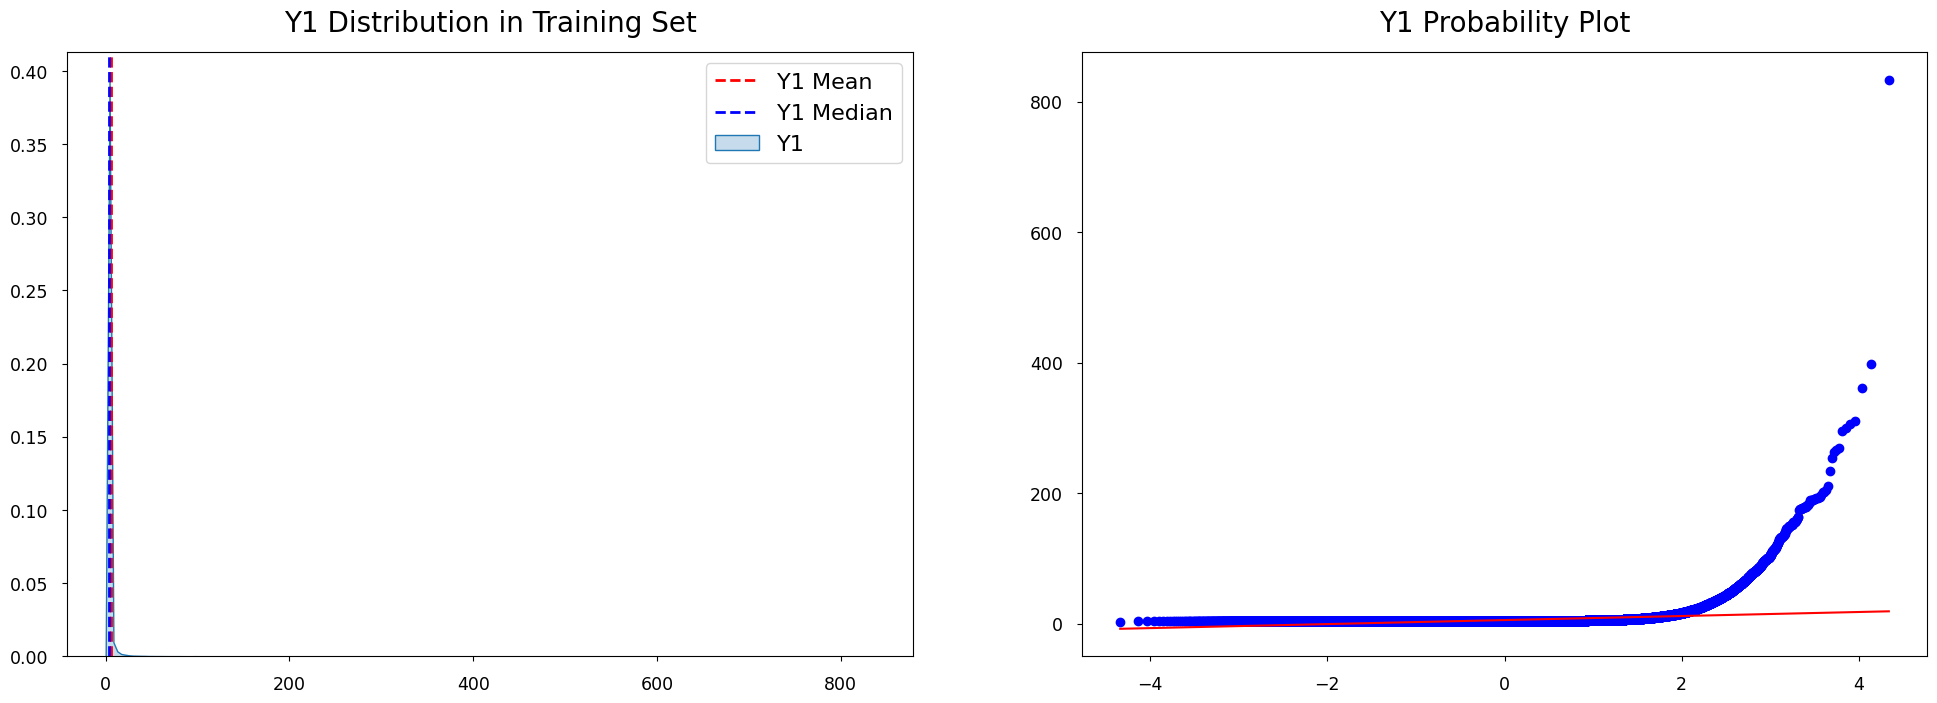

Y2
--
Mean: 114.9807  -  Median: 27.3973  -  Std: 185.2855
Min: 0.0000  -  25%: 8.2192  -  50%: 27.3973  -  75%: 131.5068  -  Max: 1000.0000
Skew: 2.2973  -  Kurtosis: 5.0405
Missing Values: 0/96298 (0.0000%)


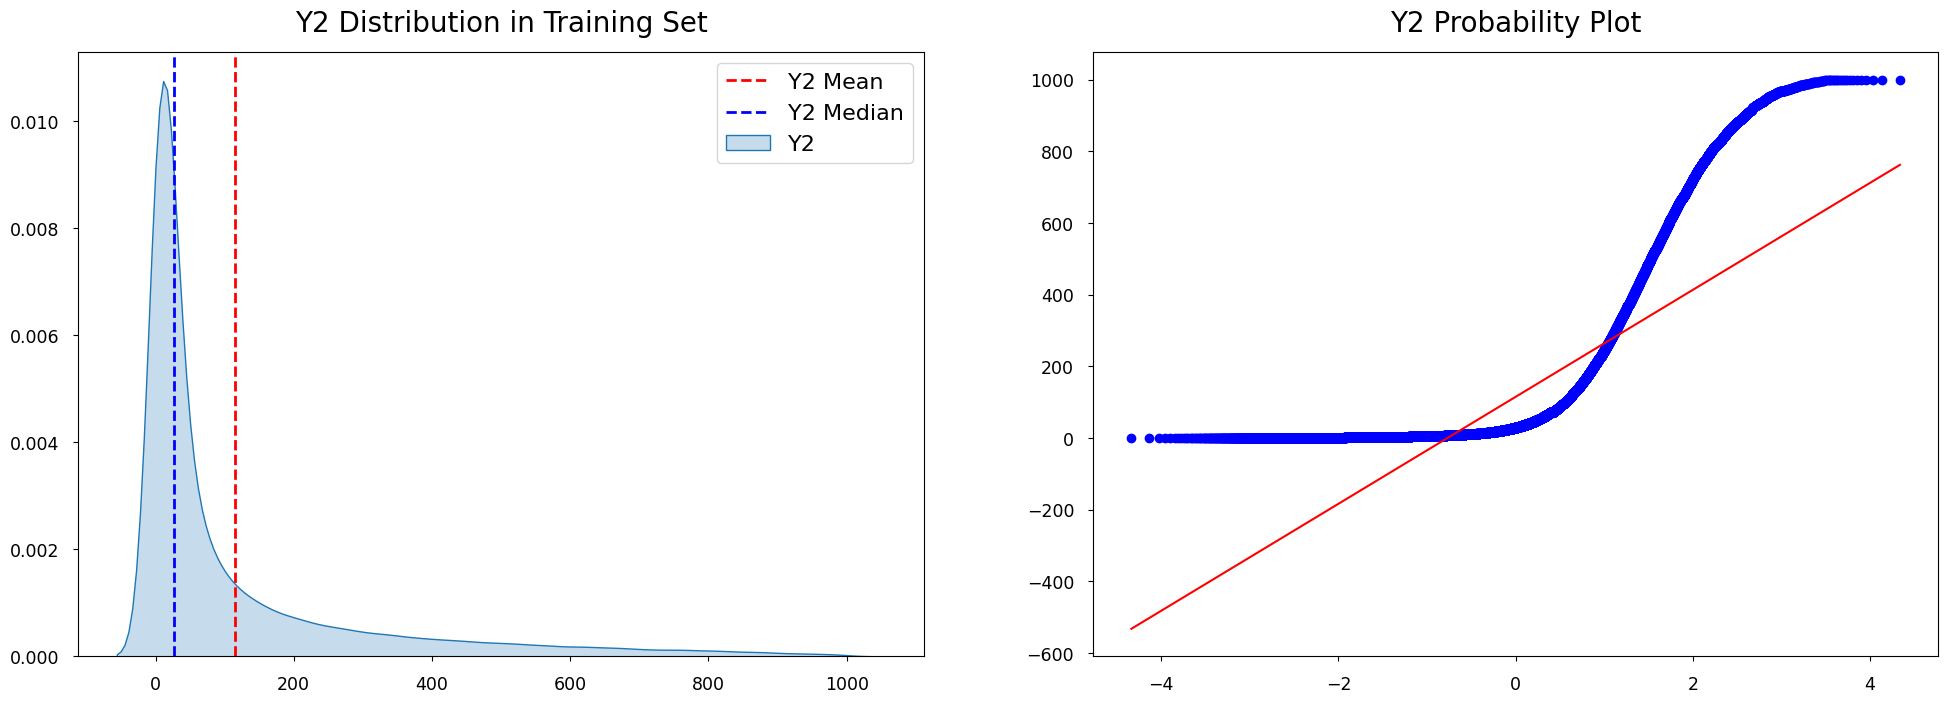

In [61]:
for i in df_train.columns:
    if(i=='CATEGORY_1' or i=='CATEGORY_2'):
        continue
    visualize_target(i)

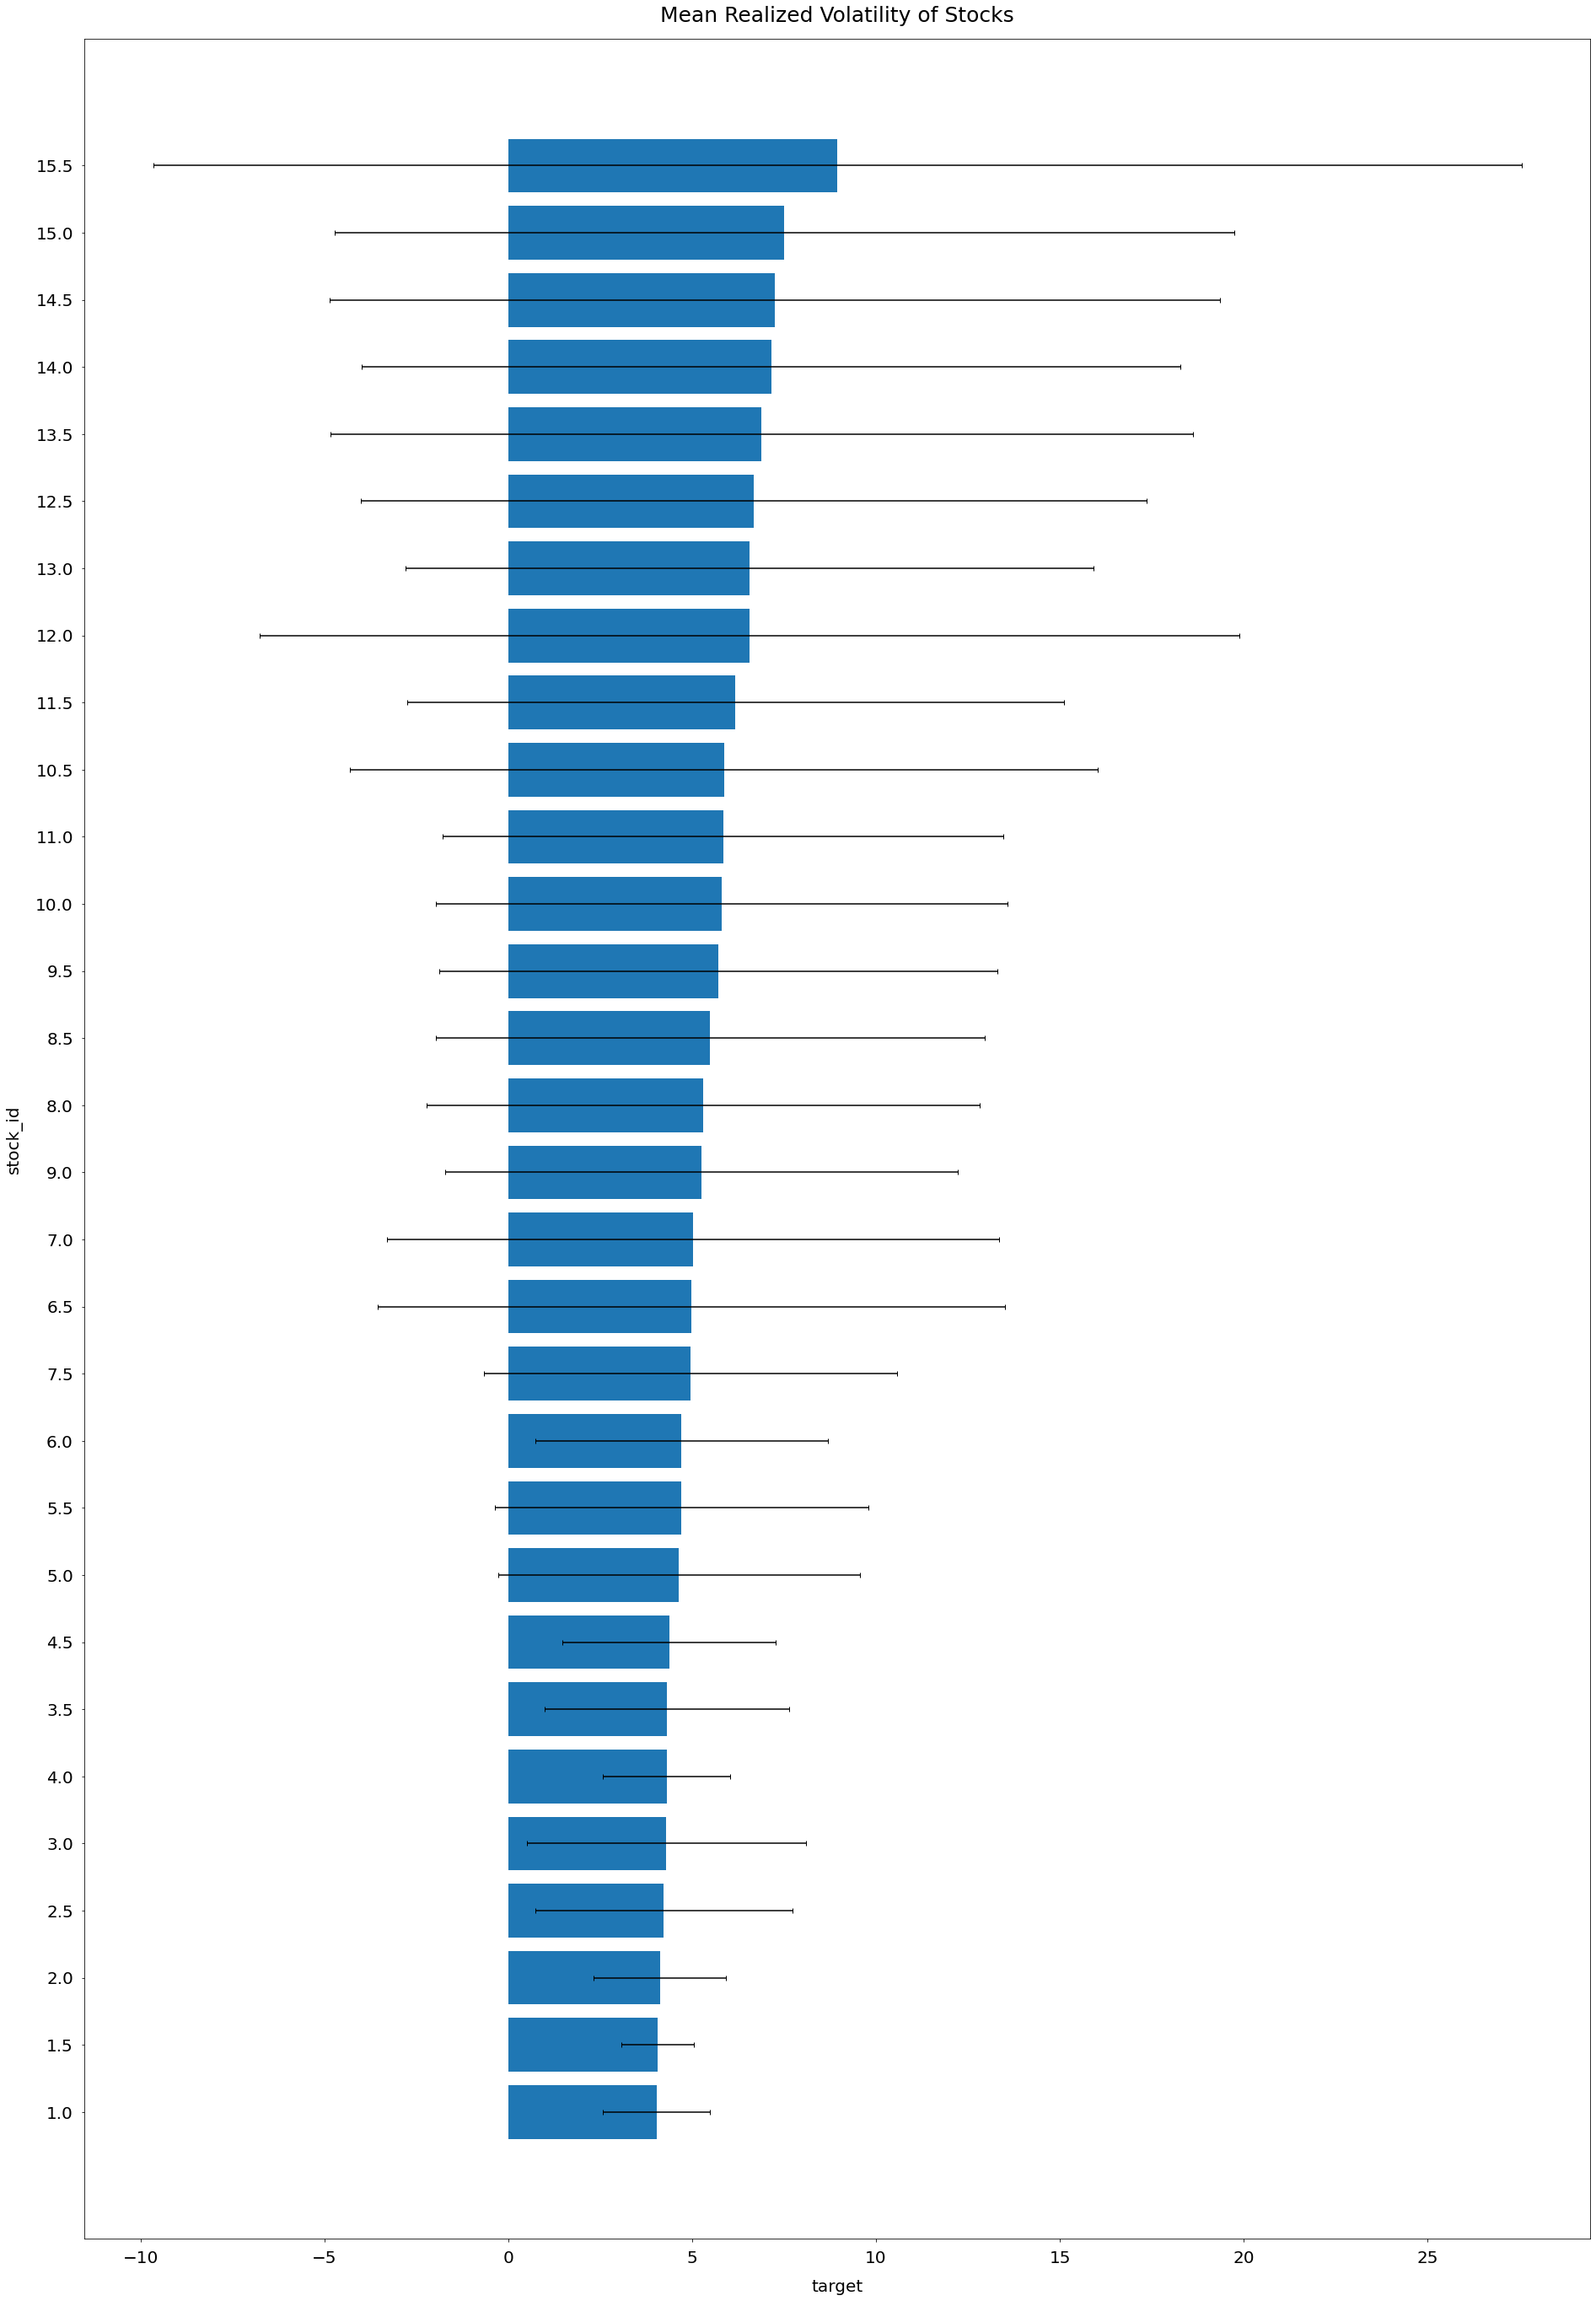

In [13]:
target_means = df_train.groupby('SEQUENCE_NO')['Y1'].mean()
target_stds = df_train.groupby('SEQUENCE_NO')['Y1'].std()

target_means_and_stds = pd.concat([target_means, target_stds], axis=1)
target_means_and_stds.columns = ['mean', 'std']
target_means_and_stds.sort_values(by='mean', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(32, 48))
ax.barh(
    y=np.arange(len(target_means_and_stds)),
    width=target_means_and_stds['mean'],
    xerr=target_means_and_stds['std'],
    align='center',
    ecolor='black',
    capsize=3
)

ax.set_yticks(np.arange(len(target_means_and_stds)))
ax.set_yticklabels(target_means_and_stds.index)
ax.set_xlabel('target', size=20, labelpad=15)
ax.set_ylabel('stock_id', size=20, labelpad=15)
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Mean Realized Volatility of Stocks', size=25, pad=20)

plt.show()

del target_means, target_stds, target_means_and_stds

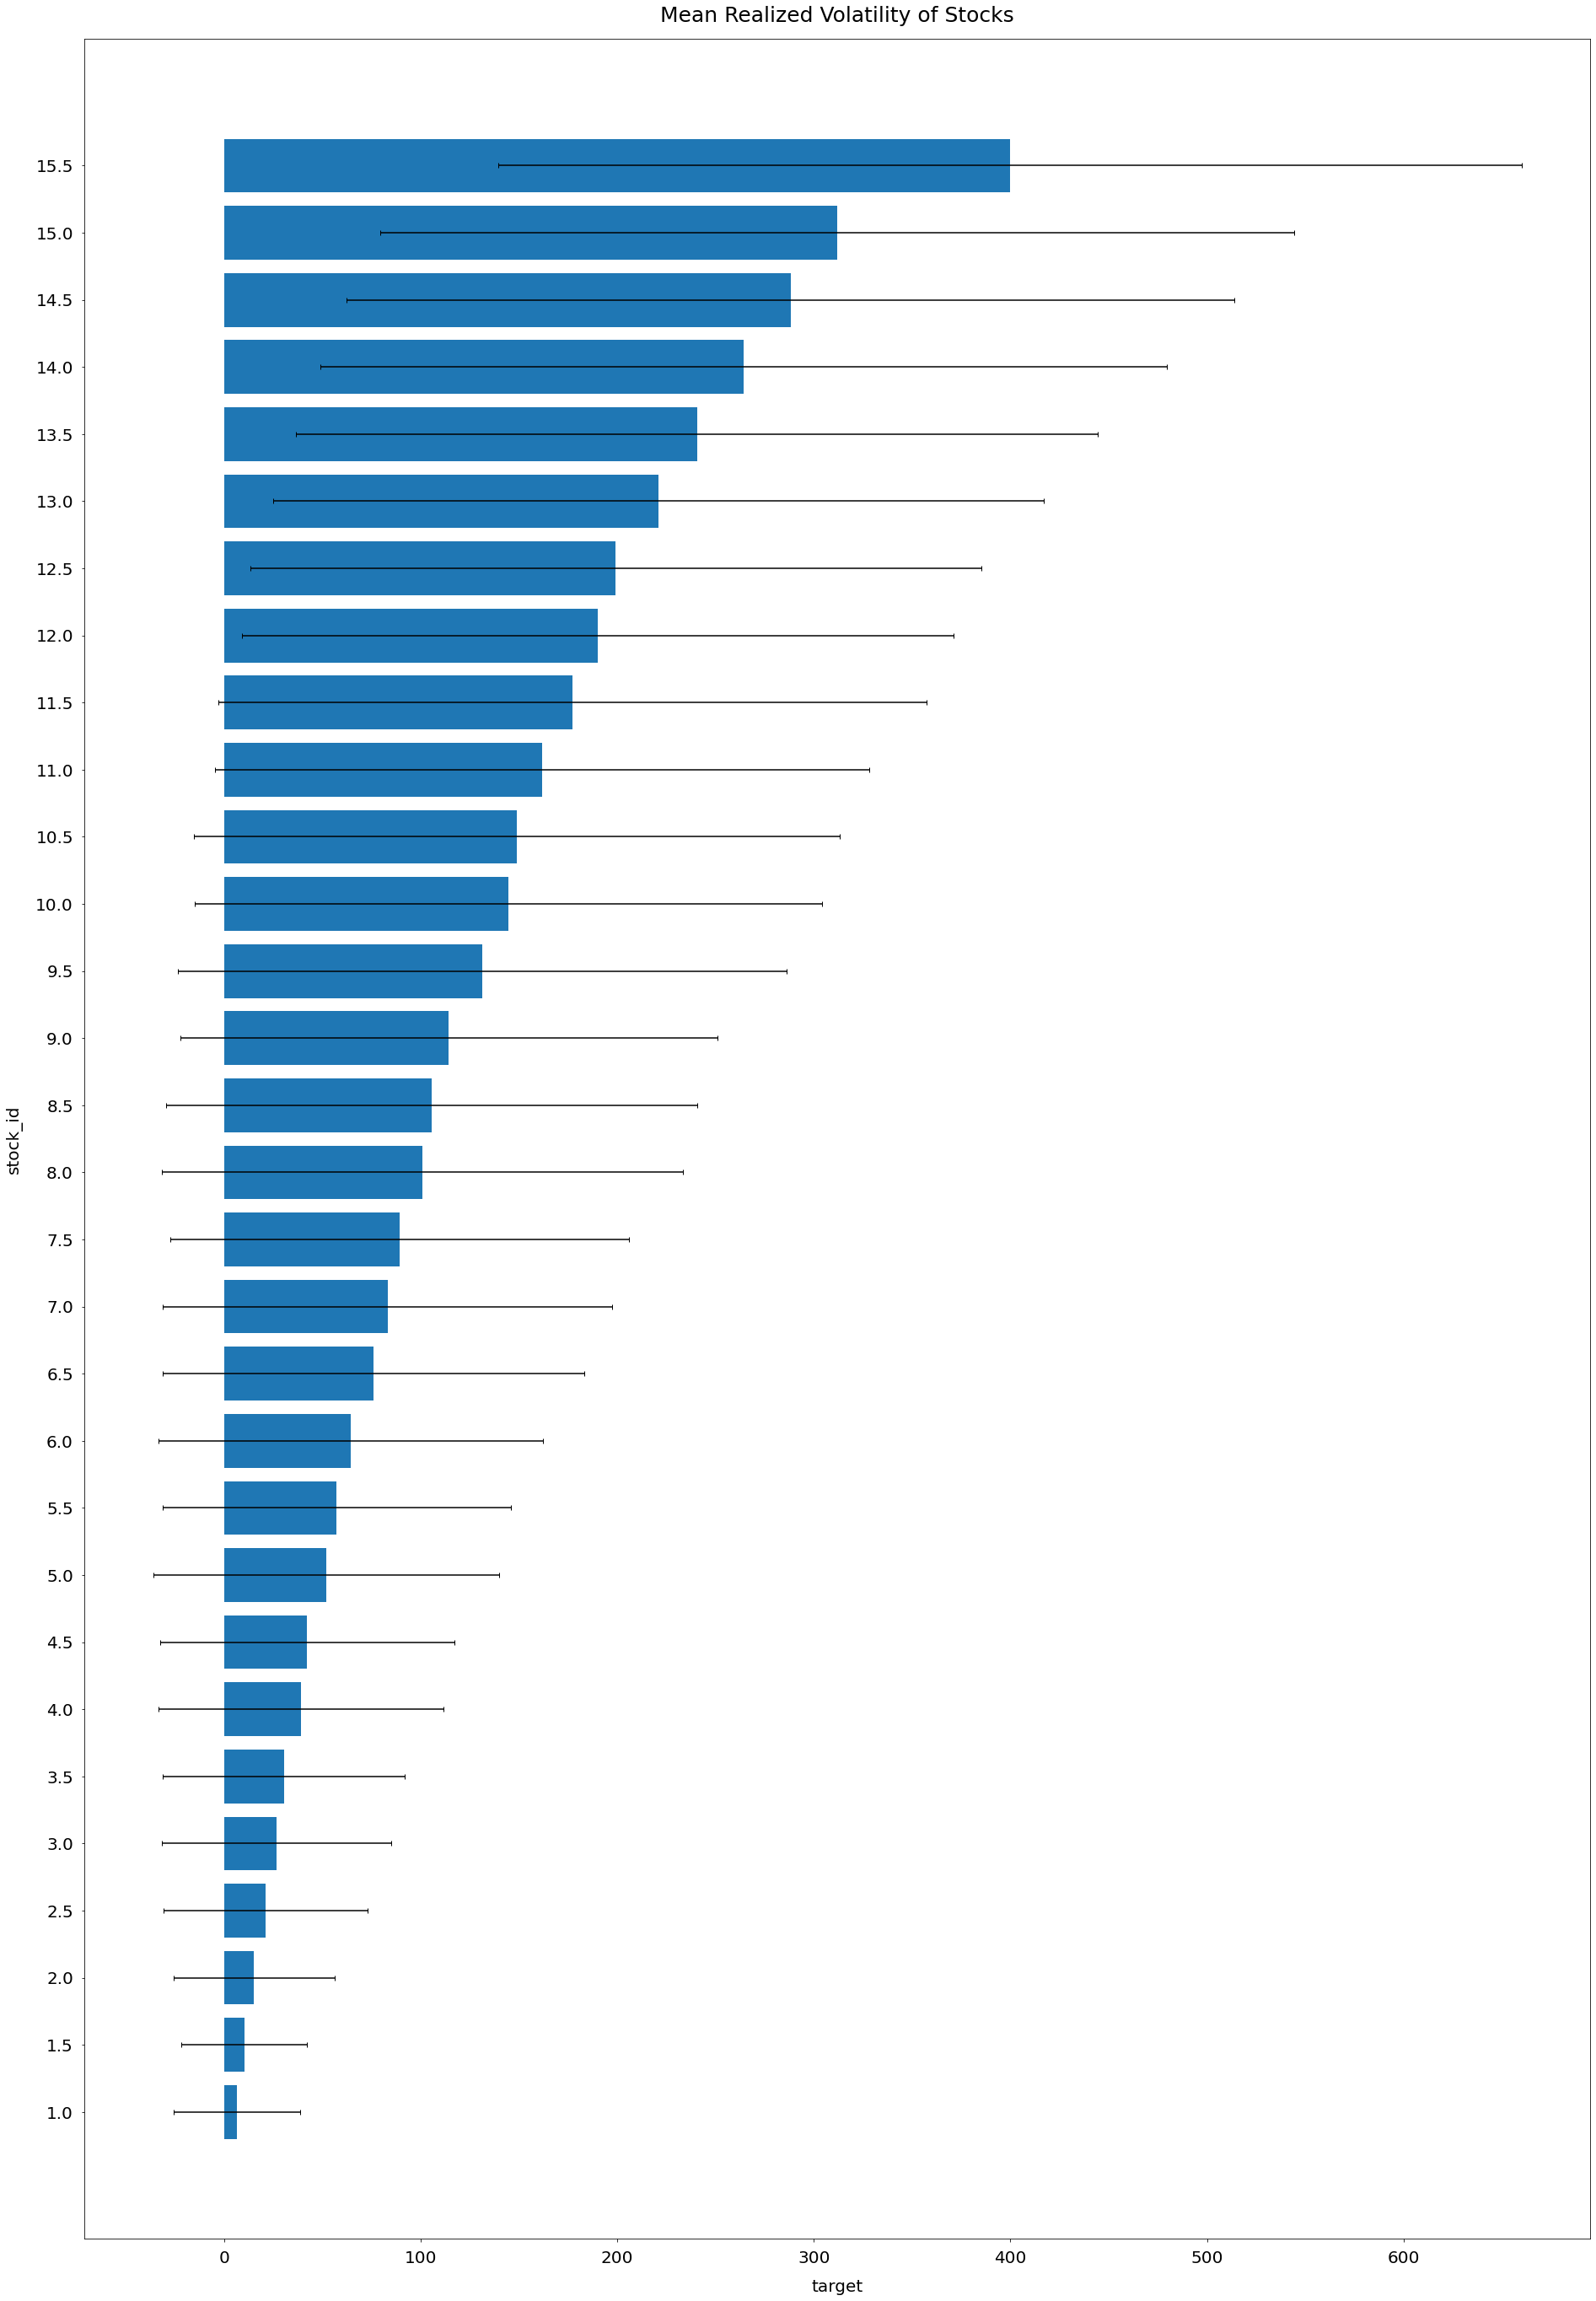

In [14]:
target_means = df_train.groupby('SEQUENCE_NO')['Y2'].mean()
target_stds = df_train.groupby('SEQUENCE_NO')['Y2'].std()

target_means_and_stds = pd.concat([target_means, target_stds], axis=1)
target_means_and_stds.columns = ['mean', 'std']
target_means_and_stds.sort_values(by='mean', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(32, 48))
ax.barh(
    y=np.arange(len(target_means_and_stds)),
    width=target_means_and_stds['mean'],
    xerr=target_means_and_stds['std'],
    align='center',
    ecolor='black',
    capsize=3
)

ax.set_yticks(np.arange(len(target_means_and_stds)))
ax.set_yticklabels(target_means_and_stds.index)
ax.set_xlabel('target', size=20, labelpad=15)
ax.set_ylabel('stock_id', size=20, labelpad=15)
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Mean Realized Volatility of Stocks', size=25, pad=20)

plt.show()

del target_means, target_stds, target_means_and_stds

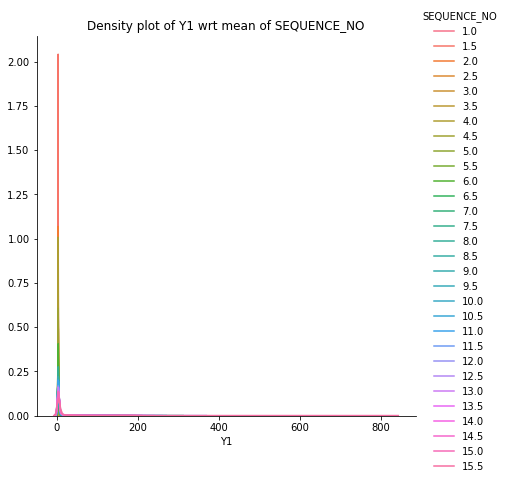

In [15]:
#plotting density plot of installments wrt each ratings
sns.FacetGrid(df_train,hue="SEQUENCE_NO",height=6)\
    .map(sns.kdeplot,"Y1")\
    .add_legend()
plt.title("Density plot of Y1 wrt mean of SEQUENCE_NO")
plt.show()

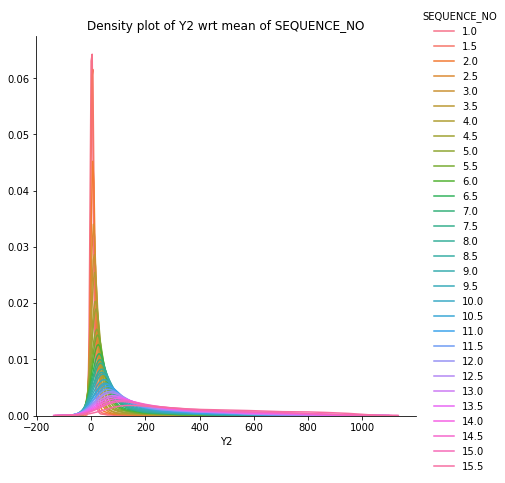

In [16]:
#plotting density plot of installments wrt each ratings
sns.FacetGrid(df_train,hue="SEQUENCE_NO",height=6)\
    .map(sns.kdeplot,"Y2")\
    .add_legend()
plt.title("Density plot of Y2 wrt mean of SEQUENCE_NO")
plt.show()

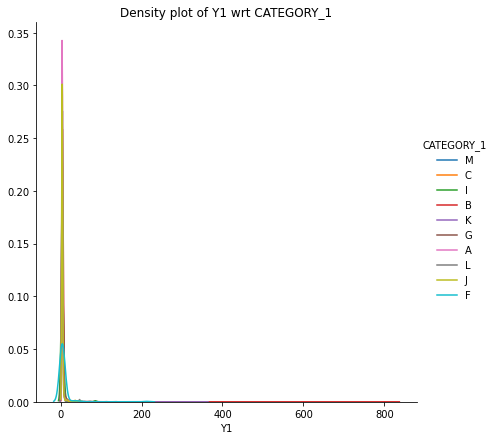

In [17]:
#plotting density plot of installments wrt each ratings
sns.FacetGrid(df_train,hue="CATEGORY_1",height=6)\
    .map(sns.kdeplot,"Y1")\
    .add_legend()
plt.title("Density plot of Y1 wrt CATEGORY_1")
plt.show()

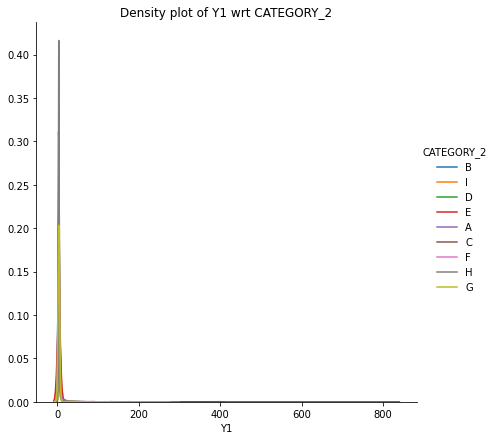

In [18]:
#plotting density plot of installments wrt each ratings
sns.FacetGrid(df_train,hue="CATEGORY_2",height=6)\
    .map(sns.kdeplot,"Y1")\
    .add_legend()
plt.title("Density plot of Y1 wrt CATEGORY_2")
plt.show()

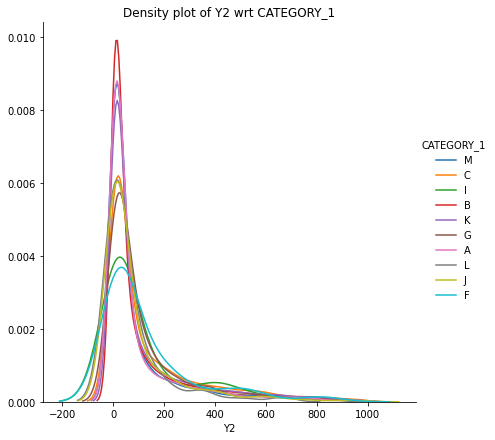

In [19]:
#plotting density plot of installments wrt each ratings
sns.FacetGrid(df_train,hue="CATEGORY_1",height=6)\
    .map(sns.kdeplot,"Y2")\
    .add_legend()
plt.title("Density plot of Y2 wrt CATEGORY_1")
plt.show()

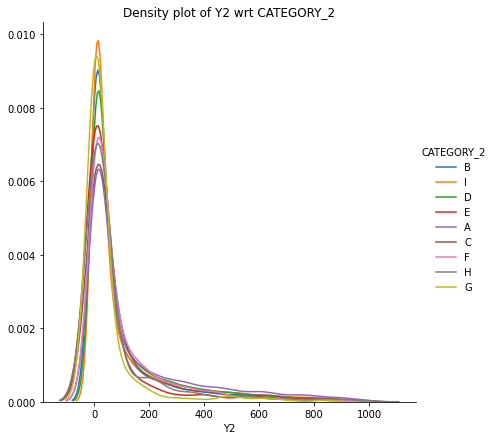

In [20]:
#plotting density plot of installments wrt each ratings
sns.FacetGrid(df_train,hue="CATEGORY_2",height=6)\
    .map(sns.kdeplot,"Y2")\
    .add_legend()
plt.title("Density plot of Y2 wrt CATEGORY_2")
plt.show()

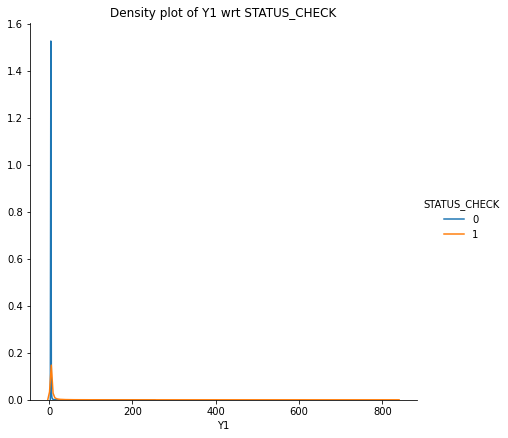

In [21]:
#plotting density plot of installments wrt each ratings
sns.FacetGrid(df_train,hue="STATUS_CHECK",height=6)\
    .map(sns.kdeplot,"Y1")\
    .add_legend()
plt.title("Density plot of Y1 wrt STATUS_CHECK")
plt.show()

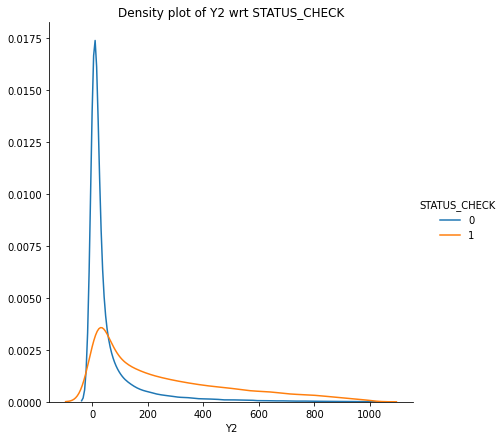

In [22]:
#plotting density plot of installments wrt each ratings
sns.FacetGrid(df_train,hue="STATUS_CHECK",height=6)\
    .map(sns.kdeplot,"Y2")\
    .add_legend()
plt.title("Density plot of Y2 wrt STATUS_CHECK")
plt.show()

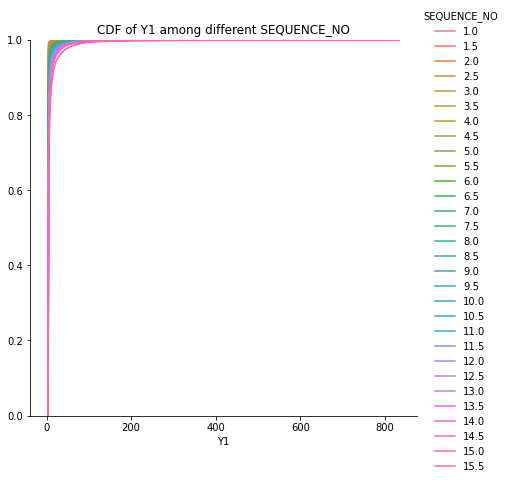

In [23]:
#plotting cdf
sns.FacetGrid(df_train,hue="SEQUENCE_NO",height=6)\
    .map(sns.ecdfplot,"Y1")\
    .add_legend()


plt.title("CDF of Y1 among different SEQUENCE_NO")
plt.xlabel("Y1")
plt.show()

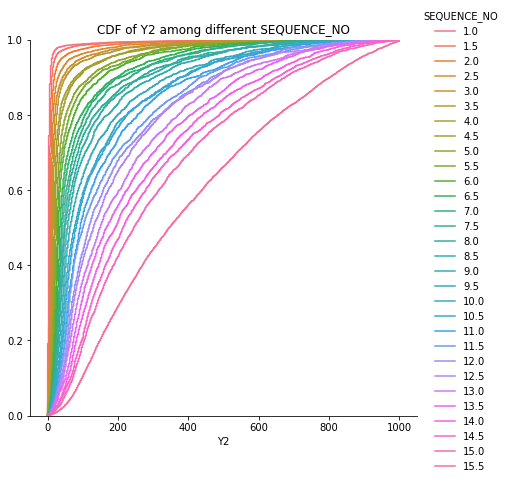

In [24]:
#plotting cdf
sns.FacetGrid(df_train,hue="SEQUENCE_NO",height=6)\
    .map(sns.ecdfplot,"Y2")\
    .add_legend()


plt.title("CDF of Y2 among different SEQUENCE_NO")
plt.xlabel("Y2")
plt.show()

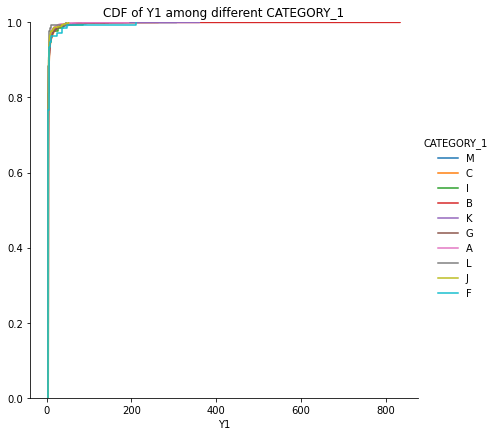

In [25]:
#plotting cdf
sns.FacetGrid(df_train,hue="CATEGORY_1",height=6)\
    .map(sns.ecdfplot,"Y1")\
    .add_legend()


plt.title("CDF of Y1 among different CATEGORY_1")
plt.xlabel("Y1")
plt.show()

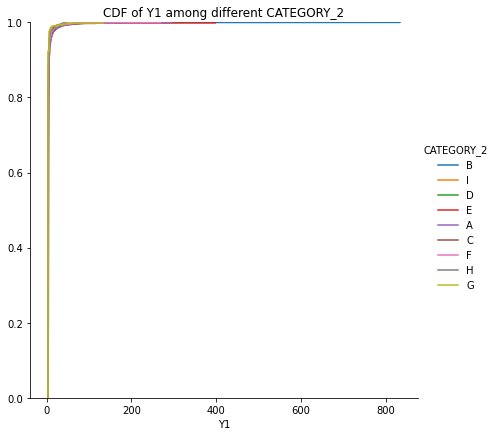

In [26]:
#plotting cdf
sns.FacetGrid(df_train,hue="CATEGORY_2",height=6)\
    .map(sns.ecdfplot,"Y1")\
    .add_legend()


plt.title("CDF of Y1 among different CATEGORY_2")
plt.xlabel("Y1")
plt.show()

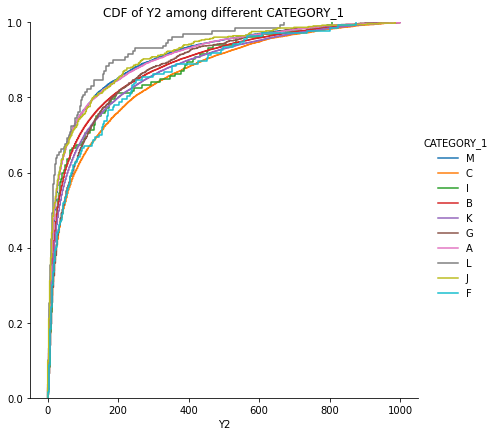

In [27]:
#plotting cdf
sns.FacetGrid(df_train,hue="CATEGORY_1",height=6)\
    .map(sns.ecdfplot,"Y2")\
    .add_legend()


plt.title("CDF of Y2 among different CATEGORY_1")
plt.xlabel("Y2")
plt.show()

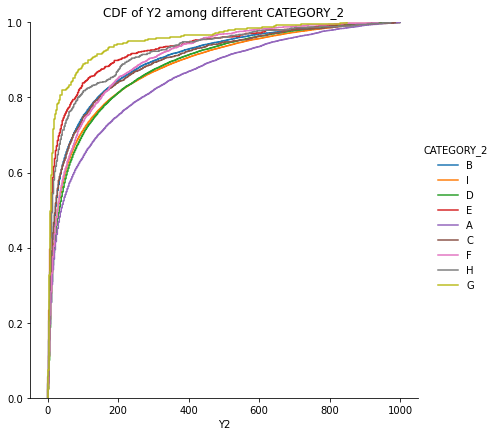

In [28]:
#plotting cdf
sns.FacetGrid(df_train,hue="CATEGORY_2",height=6)\
    .map(sns.ecdfplot,"Y2")\
    .add_legend()


plt.title("CDF of Y2 among different CATEGORY_2")
plt.xlabel("Y2")
plt.show()

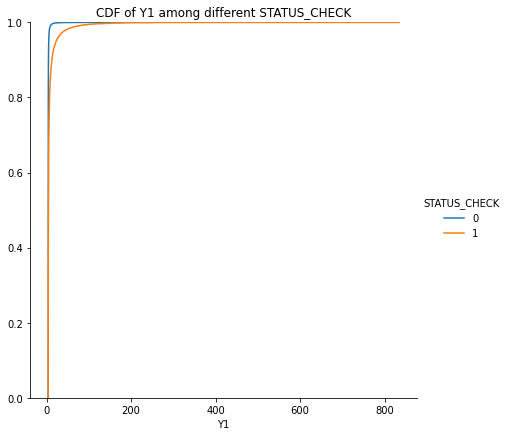

In [29]:
#plotting cdf
sns.FacetGrid(df_train,hue="STATUS_CHECK",height=6)\
    .map(sns.ecdfplot,"Y1")\
    .add_legend()


plt.title("CDF of Y1 among different STATUS_CHECK")
plt.xlabel("Y1")
plt.show()

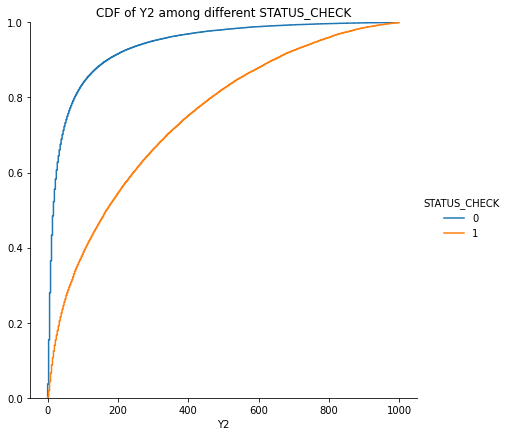

In [30]:
#plotting cdf
sns.FacetGrid(df_train,hue="STATUS_CHECK",height=6)\
    .map(sns.ecdfplot,"Y2")\
    .add_legend()


plt.title("CDF of Y2 among different STATUS_CHECK")
plt.xlabel("Y2")
plt.show()

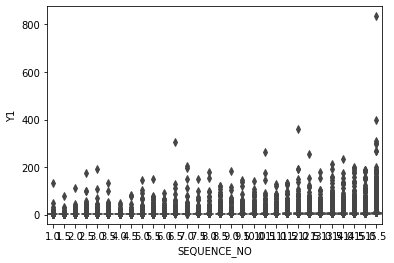

In [31]:
sns.boxplot(y="Y1",x="SEQUENCE_NO",data=df_train)
plt.show()

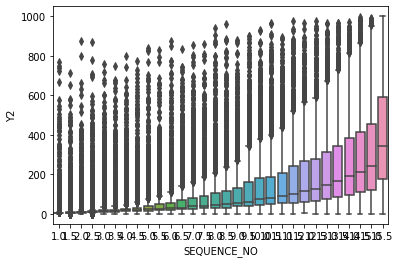

In [32]:
sns.boxplot(y="Y2",x="SEQUENCE_NO",data=df_train)
plt.show()

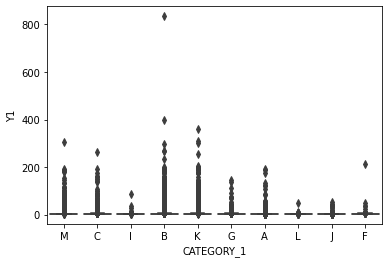

In [33]:
sns.boxplot(y="Y1",x="CATEGORY_1",data=df_train)
plt.show()

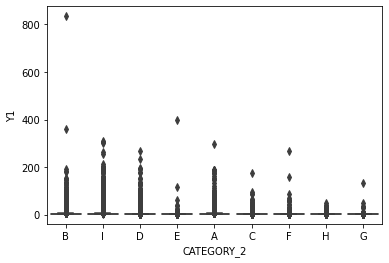

In [34]:
sns.boxplot(y="Y1",x="CATEGORY_2",data=df_train)
plt.show()

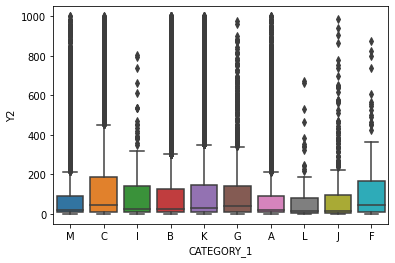

In [35]:
sns.boxplot(y="Y2",x="CATEGORY_1",data=df_train)
plt.show()

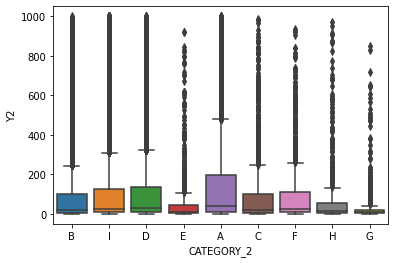

In [36]:
sns.boxplot(y="Y2",x="CATEGORY_2",data=df_train)
plt.show()

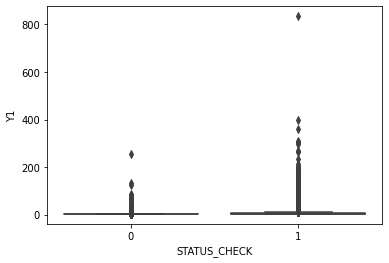

In [37]:
sns.boxplot(y="Y1",x="STATUS_CHECK",data=df_train)
plt.show()

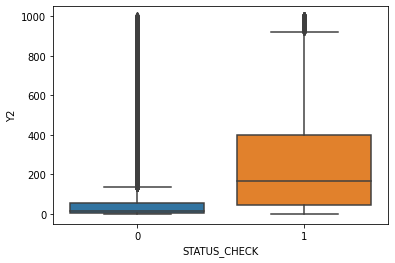

In [38]:
sns.boxplot(y="Y2",x="STATUS_CHECK",data=df_train)
plt.show()

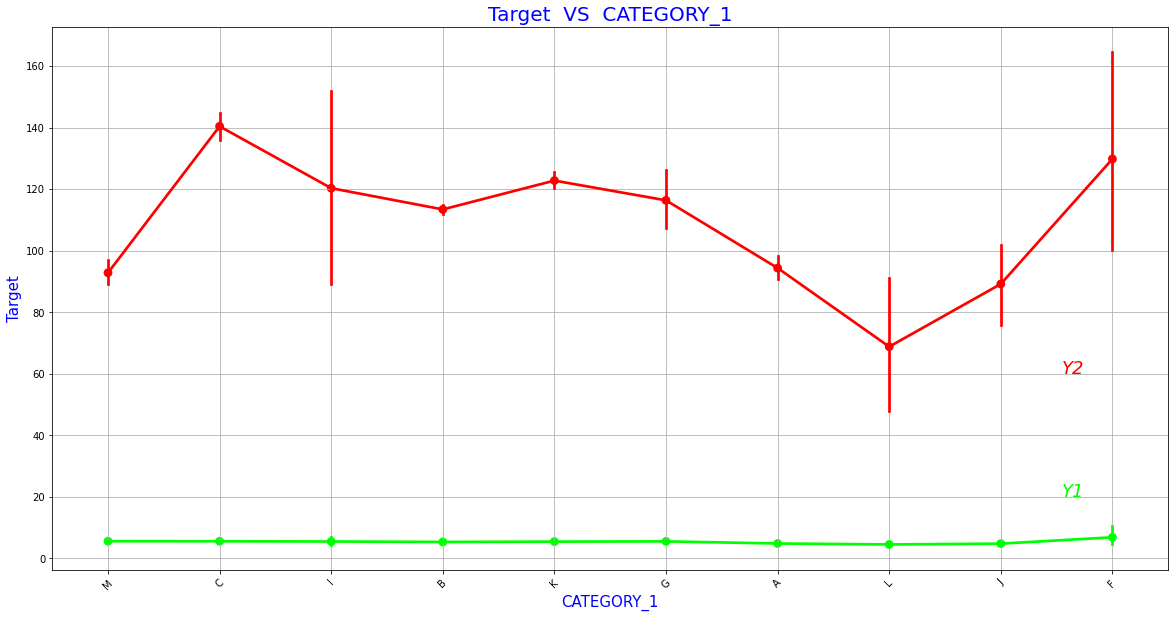

In [55]:
#Visualization
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='CATEGORY_1',y='Y1',data=df_train,color='lime',alpha=0.8)
sns.pointplot(x='CATEGORY_1',y='Y2',data=df_train,color='red',alpha=0.8)
plt.text(8.55,60,'Y2',color='red',fontsize = 18,style = 'italic')
plt.text(8.55,20,'Y1',color='lime',fontsize = 18,style = 'italic')
plt.xticks(rotation=45)
plt.xlabel('CATEGORY_1',fontsize = 15,color='blue')
plt.ylabel('Target',fontsize = 15,color='blue')
plt.title('Target  VS  CATEGORY_1',fontsize = 20,color='blue')
plt.grid()
plt.show()

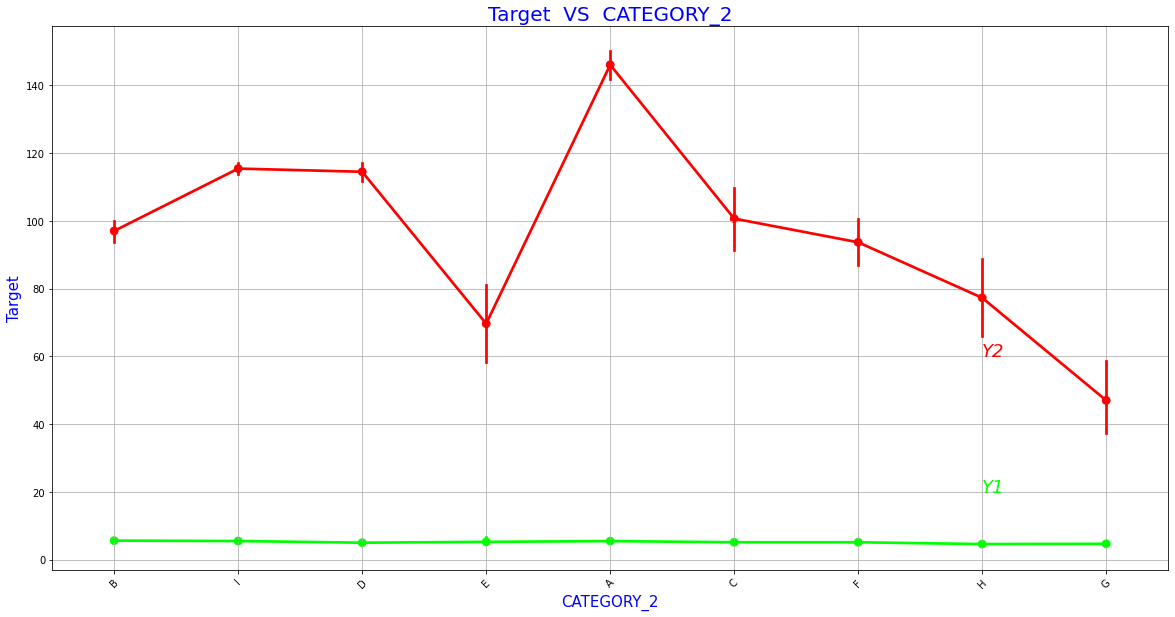

In [58]:
#Visualization
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='CATEGORY_2',y='Y1',data=df_train,color='lime',alpha=0.8)
sns.pointplot(x='CATEGORY_2',y='Y2',data=df_train,color='red',alpha=0.8)
plt.text(7,60,'Y2',color='red',fontsize = 18,style = 'italic')
plt.text(7,20,'Y1',color='lime',fontsize = 18,style = 'italic')
plt.xticks(rotation=45)
plt.xlabel('CATEGORY_2',fontsize = 15,color='blue')
plt.ylabel('Target',fontsize = 15,color='blue')
plt.title('Target  VS  CATEGORY_2',fontsize = 20,color='blue')
plt.grid()
plt.show()

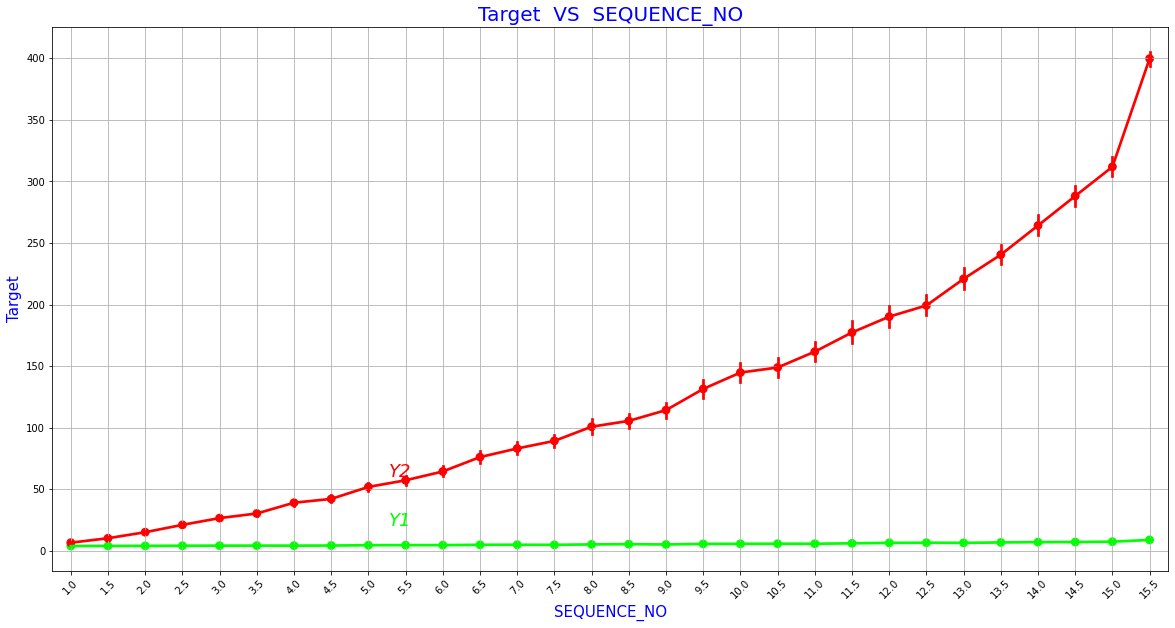

In [57]:
#Visualization
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='SEQUENCE_NO',y='Y1',data=df_train,color='lime',alpha=0.8)
sns.pointplot(x='SEQUENCE_NO',y='Y2',data=df_train,color='red',alpha=0.8)
plt.text(8.55,60,'Y2',color='red',fontsize = 18,style = 'italic')
plt.text(8.55,20,'Y1',color='lime',fontsize = 18,style = 'italic')
plt.xticks(rotation=45)
plt.xlabel('SEQUENCE_NO',fontsize = 15,color='blue')
plt.ylabel('Target',fontsize = 15,color='blue')
plt.title('Target  VS  SEQUENCE_NO',fontsize = 20,color='blue')
plt.grid()
plt.show()

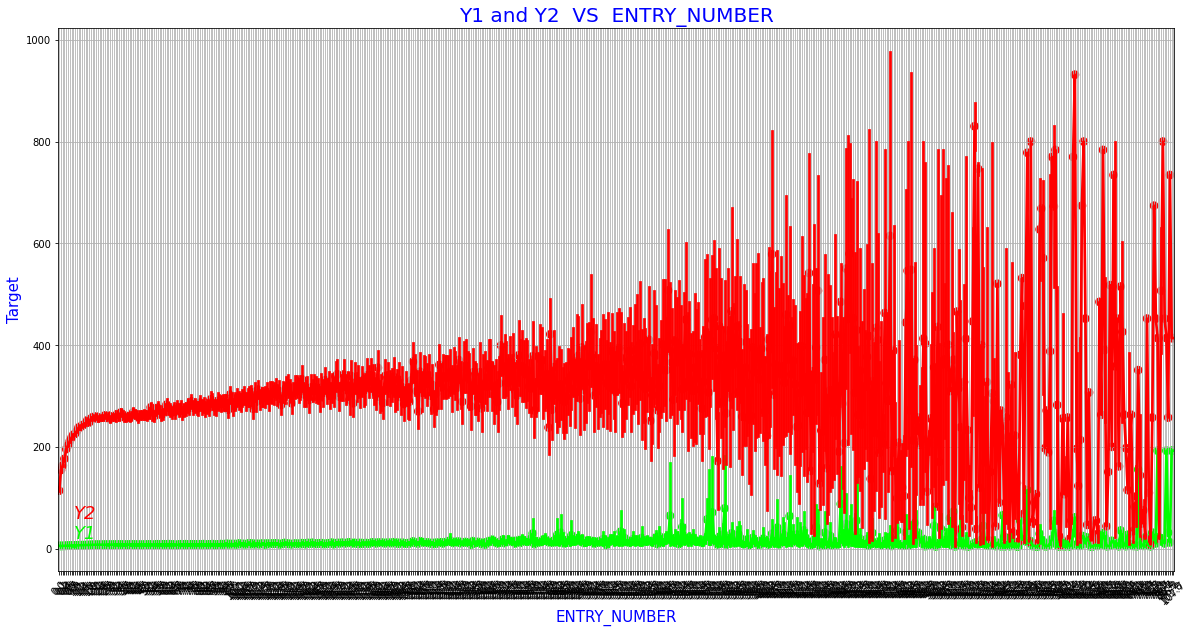

In [64]:
#Visualization
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='ENTRY_NUMBER',y='Y1',data=train,color='lime',alpha=0.8)
sns.pointplot(x='ENTRY_NUMBER',y='Y2',data=train,color='red',alpha=0.8)
plt.text(8.55,60,'Y2',color='red',fontsize = 18,style = 'italic')
plt.text(8.55,20,'Y1',color='lime',fontsize = 18,style = 'italic')
plt.xticks(rotation=45)
plt.xlabel('ENTRY_NUMBER',fontsize = 15,color='blue')
plt.ylabel('Target',fontsize = 15,color='blue')
plt.title('Y1 and Y2  VS  ENTRY_NUMBER',fontsize = 20,color='blue')
plt.grid()
plt.show()

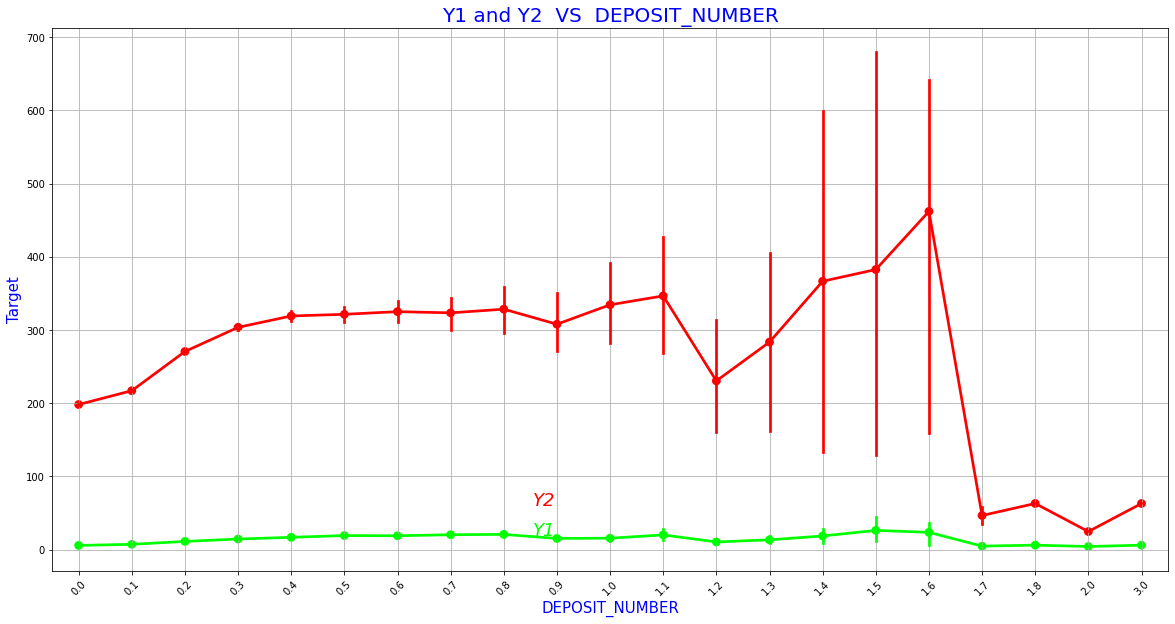

In [65]:
#Visualization
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DEPOSIT_NUMBER',y='Y1',data=train,color='lime',alpha=0.8)
sns.pointplot(x='DEPOSIT_NUMBER',y='Y2',data=train,color='red',alpha=0.8)
plt.text(8.55,60,'Y2',color='red',fontsize = 18,style = 'italic')
plt.text(8.55,20,'Y1',color='lime',fontsize = 18,style = 'italic')
plt.xticks(rotation=45)
plt.xlabel('DEPOSIT_NUMBER',fontsize = 15,color='blue')
plt.ylabel('Target',fontsize = 15,color='blue')
plt.title('Y1 and Y2  VS  DEPOSIT_NUMBER',fontsize = 20,color='blue')
plt.grid()
plt.show()

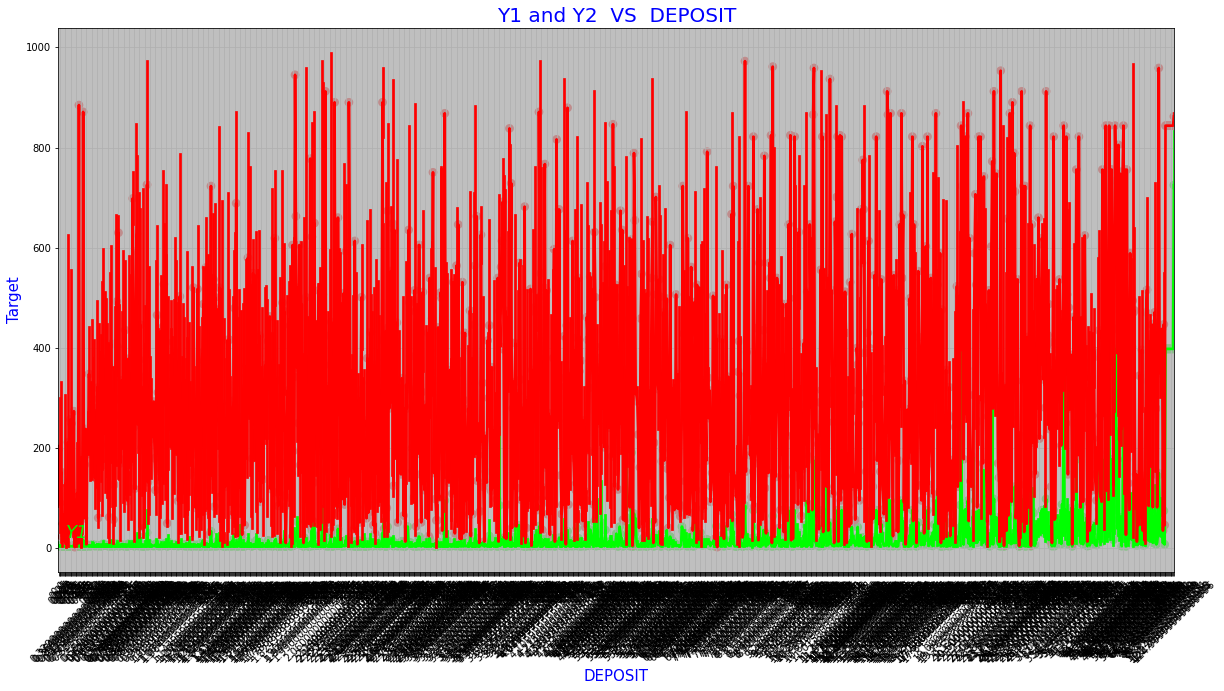

In [66]:
#Visualization
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DEPOSIT',y='Y1',data=train,color='lime',alpha=0.8)
sns.pointplot(x='DEPOSIT',y='Y2',data=train,color='red',alpha=0.8)
plt.text(8.55,60,'Y2',color='red',fontsize = 18,style = 'italic')
plt.text(8.55,20,'Y1',color='lime',fontsize = 18,style = 'italic')
plt.xticks(rotation=45)
plt.xlabel('DEPOSIT',fontsize = 15,color='blue')
plt.ylabel('Target',fontsize = 15,color='blue')
plt.title('Y1 and Y2  VS  DEPOSIT',fontsize = 20,color='blue')
plt.grid()
plt.show()

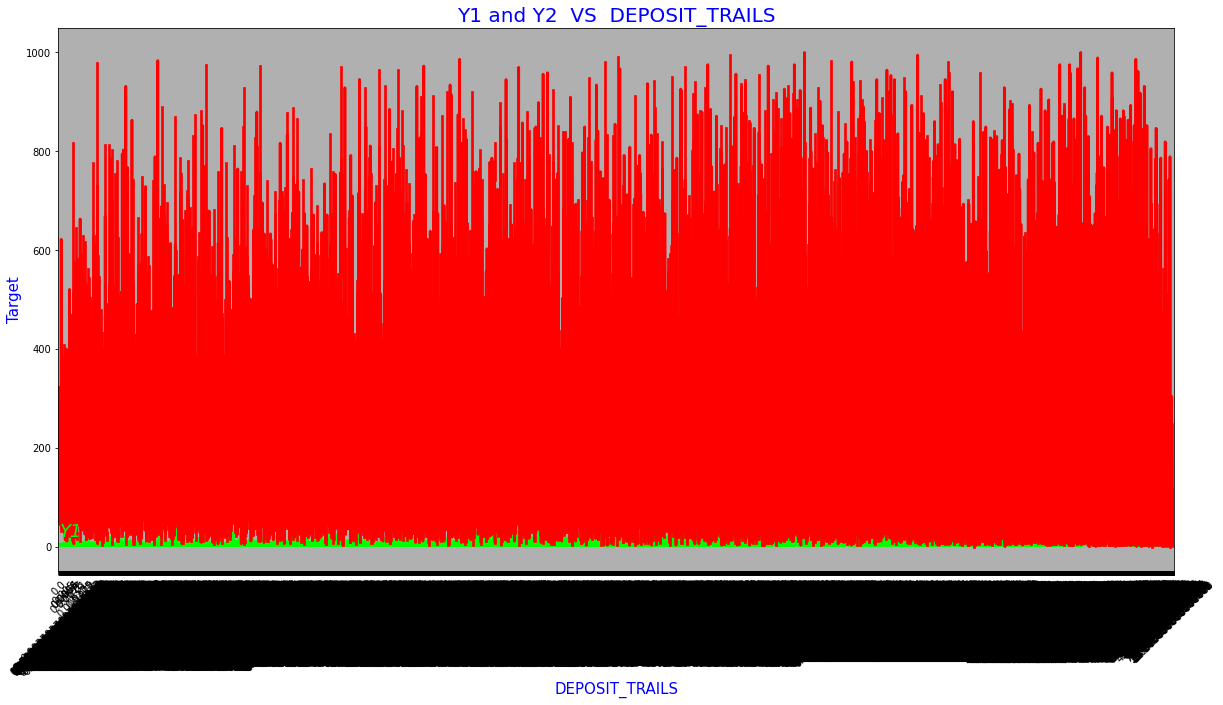

In [73]:
#Visualization
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DEPOSIT_TRAILS',y='Y1',data=train,color='lime',alpha=0.8)
sns.pointplot(x='DEPOSIT_TRAILS',y='Y2',data=train,color='red',alpha=0.8)
plt.text(8.55,60,'Y2',color='red',fontsize = 18,style = 'italic')
plt.text(8.55,20,'Y1',color='lime',fontsize = 18,style = 'italic')
plt.xticks(rotation=45)
plt.xlabel('DEPOSIT_TRAILS',fontsize = 15,color='blue')
plt.ylabel('Target',fontsize = 15,color='blue')
plt.title('Y1 and Y2  VS  DEPOSIT_TRAILS',fontsize = 20,color='blue')
plt.grid()
plt.show()

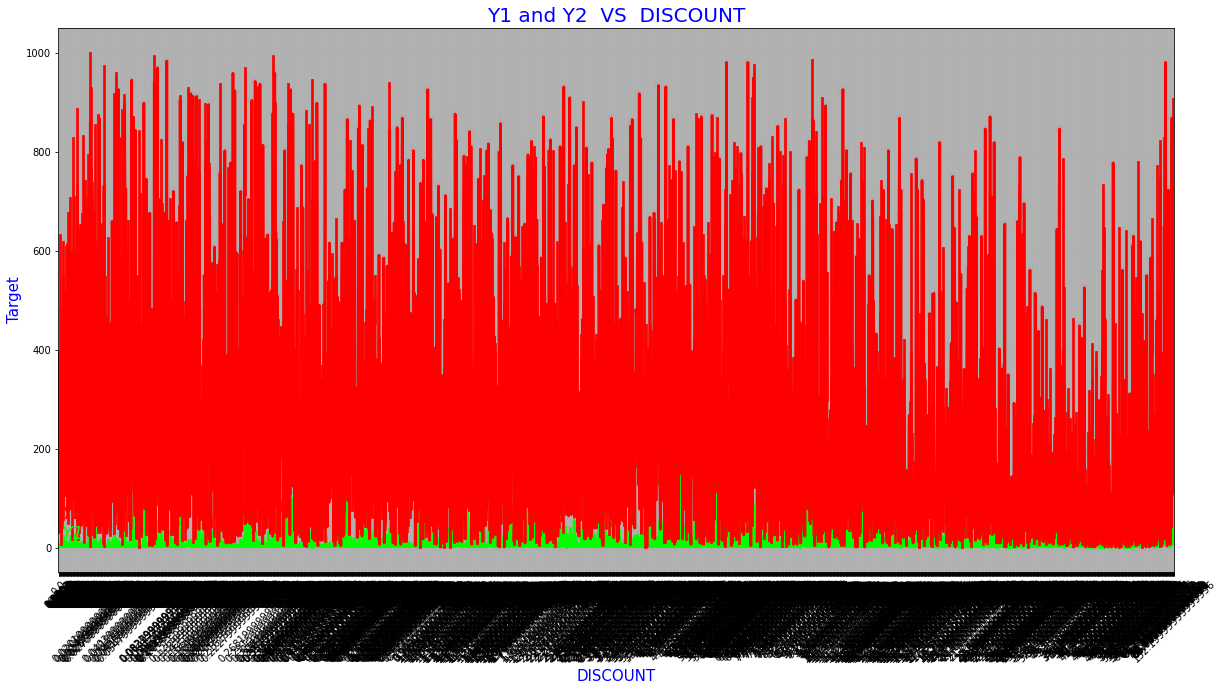

In [74]:
#Visualization
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DISCOUNT',y='Y1',data=train,color='lime',alpha=0.8)
sns.pointplot(x='DISCOUNT',y='Y2',data=train,color='red',alpha=0.8)
plt.text(8.55,60,'Y2',color='red',fontsize = 18,style = 'italic')
plt.text(8.55,20,'Y1',color='lime',fontsize = 18,style = 'italic')
plt.xticks(rotation=45)
plt.xlabel('DISCOUNT',fontsize = 15,color='blue')
plt.ylabel('Target',fontsize = 15,color='blue')
plt.title('Y1 and Y2  VS  DISCOUNT',fontsize = 20,color='blue')
plt.grid()
plt.show()

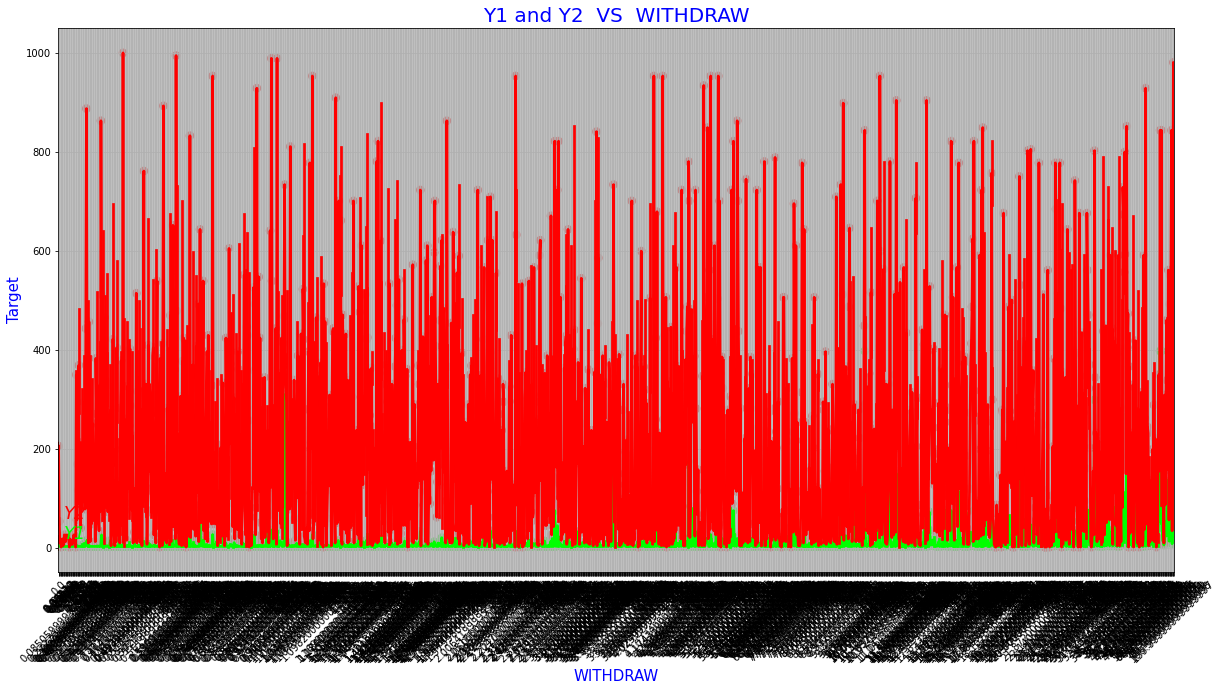

In [76]:
#Visualization
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='WITHDRAW',y='Y1',data=train,color='lime',alpha=0.8)
sns.pointplot(x='WITHDRAW',y='Y2',data=train,color='red',alpha=0.8)
plt.text(8.55,60,'Y2',color='red',fontsize = 18,style = 'italic')
plt.text(8.55,20,'Y1',color='lime',fontsize = 18,style = 'italic')
plt.xticks(rotation=45)
plt.xlabel('WITHDRAW',fontsize = 15,color='blue')
plt.ylabel('Target',fontsize = 15,color='blue')
plt.title('Y1 and Y2  VS  WITHDRAW',fontsize = 20,color='blue')
plt.grid()
plt.show()